# Init

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS, CSS4_COLORS
from tqdm.auto import tqdm
import seaborn as sns
from datetime import datetime, timedelta
import math
import pickle
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import mode, permutation_test, pearsonr, linregress, rankdata
from scipy.spatial import distance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from scipy import interpolate
from pathlib import Path
import functools
import cv2
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['axes.grid'] = False
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['ytick.left'] = True
mpl.rcParams["font.family"] = "Helvetica"
# mpl.rcParams["xtick.direction"] = "in"
mpl.rc('axes',edgecolor='black')
import os
if Path('.').resolve().name != 'Arena':
    os.chdir('../Arena')
import config
from db_models import ORM, Experiment, Strike, Block, Video, Trial, VideoPrediction
from analysis.pose_utils import plot_regression, colorline, pixels2cm, fit_circle
from analysis.pose import DLCArenaPose, SpatialAnalyzer
from analysis.predictors.tongue_out import TongueOutAnalyzer, TONGUE_CLASS
from analysis.strikes.strikes import Loader, StrikeAnalyzer
from analysis.predictors.trajectories import TrajClassifier, TRAJ_DIR, LSTMWithAttention, Attention, LizardTrajDataSet

In [3]:
orm = ORM()
sns.set_context('paper', font_scale=1.4)

### Constants

In [4]:
FIGURE_PATH = '/media/sil2/Data/regev/Papers/internal_models'
BAD_ANIMALS = ['PV03', 'PV26', 'PV72', 'PV87', 'PV88', 'PV90', 'PV101', 'PV119', 'PV144']
SCREEN_Y_POS = {'reptilearn4': -4.3, 'msi-regev': 0.06}
SCREEN_START_X = {'reptilearn4': 5.59, 'msi-regev': 3.2}
SCREEN_PIX_CM = {'reptilearn4': 52.704/1920, 'msi-regev': 34.3/1920}
PLT_COLORS = list(TABLEAU_COLORS.values()) + list(CSS4_COLORS.values())
COLORS = {
    'PV42': '#1f77b4',
    'PV43': '#17becf',
    'PV85': '#ff7f0e',
    'PV91': '#2ca02c',
    'PV80': '#d62728',
    'PV95': '#bcbd22',
    'PV97': '#9467bd',
    'PV88': '#8c564b',
    'PV99': '#e377c2',
    'PV148': '#90EE90',
    'PV163': '#7f7f7f',
}
PLT_COLORS = [c for c in PLT_COLORS if c not in COLORS.values()]
traj_model_paths = {
    'PV42': ('traj_classifier_PV42_random_low_horizontal/20240903_170358',
             'traj_classifier_PV42_random_low_horizontal/20240905_154550'),
    'PV163': ('traj_classifier_PV163_random_low_horizontal/20240903_125814',
              'traj_classifier_PV163_random_low_horizontal/20240905_152715'),
    'PV91': ('traj_classifier_PV91_random_low_horizontal/20240903_112847',
             'traj_classifier_PV91_random_low_horizontal/20240905_152305'),
    'PV80': ('traj_classifier_PV80_random_low_horizontal/20240903_152757',
             'traj_classifier_PV80_random_low_horizontal/20240905_155821'),
    'PV85': ('traj_classifier_PV85_random_low_horizontal/20240905_192044',
             'traj_classifier_PV85_random_low_horizontal/20240908_121815'),
    'PV95': ('traj_classifier_PV95_random_low_horizontal/20240905_145828',
             'traj_classifier_PV95_random_low_horizontal/20240905_180929'),
    'PV99': ('traj_classifier_PV99_random_low_horizontal/20240903_135446',
             'traj_classifier_PV99_random_low_horizontal/20240905_153634'),
}
circle_traj_models_path = {
    'PV42': ('traj_classifier_PV42_circle/20240904_203232', ''),
    'PV163': ('traj_classifier_PV163_circle/20240904_071718', ''),
    'PV91': ('traj_classifier_PV91_circle/20240904_193403', ''),
    'PV80': ('traj_classifier_PV80_circle/20240904_101710', ''),
    'PV99': ('traj_classifier_PV99_circle/20240904_080452', '')
}

### Load strikes data (df)

In [5]:
def add_strike_num_in_trial(xf):
    xf = xf.sort_values(by='time').copy()
    xf['strike_num_in_trial'] = np.arange(1, len(xf)+1)
    return xf

def analyze_db_data():
    with orm.session() as s:
        orm_res = s.query(Strike, Trial, Block, Experiment).join(Trial, Trial.id == Strike.trial_id).join(Block, Block.id == Strike.block_id).join(Experiment, Experiment.id == Block.experiment_id).filter(
            Experiment.arena.in_(['reptilearn4', 'msi-regev']),
            Experiment.animal_id.not_in(BAD_ANIMALS),
            Experiment.animal_id.startswith('PV'),
            Experiment.start_time > '2023-04-18'
        ).all()
    df_ = []
    for strk, tr, blk, exp in orm_res:
        miss_distance = np.sqrt((strk.x - strk.bug_x)**2 + (strk.y - strk.bug_y)**2)
        df_.append({'strike_id': strk.id, 'time': strk.time, 'animal_id': exp.animal_id, 'miss_distance': miss_distance,
                    'pred_distance': strk.prediction_distance, 'movement_type': blk.movement_type, 'bug_speed': get_bug_speed(tr, blk.movement_type),
                    'calc_speed': strk.calc_speed, 'proj_strike': strk.projected_strike_coords, 'bug_size': strk.bug_size,
                    'bug_x': strk.bug_x, 'bug_y': strk.bug_y, 'strike_x': strk.x, 'strike_y': strk.y,
                    'proj_bug_x': strk.projected_leap_coords and strk.projected_leap_coords[0], 'is_hit': strk.is_hit, 
                    'trial_id': strk.trial_id, 'block_id': blk.id, 'arena_name': exp.arena})

    df_ = pd.DataFrame(df_)
    df_['day'] = df_.time.dt.floor('d').copy()
    df_['trial_id'] = df_.trial_id.astype('Int32')
    df_['proj_strike_x'] = df_.proj_strike.map(lambda x: x[0] if x and len(x)==2 else None)
    df_['proj_strike_y'] = df_.proj_strike.map(lambda x: x[1] if x and len(x)==2 else None)
    # df_['movement_type'] = df_.movement_type.replace({'low_horizontal': 'random_low_horizontal'})
    df_.drop(columns=['proj_strike'], inplace=True)

    for animal_id in df_.animal_id.unique():
        af_ = df_.query(f'animal_id=="{animal_id}"').sort_values(by='strike_id')
        first_day = af_.day.sort_values().iloc[0]
        df_.loc[af_.index, 'day_num'] = (af_.day - first_day).dt.days
        
    df_ = df_.groupby('trial_id').apply(add_strike_num_in_trial).reset_index(drop=True)
    df_ = df_.sort_values(by='time')
    return df_

def convert_to_cm(df, col):
    def _convert(row):
        arena = row['arena_name']
        return row[col] * SCREEN_PIX_CM[arena]
    
    return df.apply(_convert, axis=1)

def get_bug_speed(tr, movement_type):
    bug_speed = None
    if tr.bug_trajectory is not None:
        bug_traj = pd.DataFrame(tr.bug_trajectory)
        dx = np.sqrt(bug_traj.x.diff() ** 2 + bug_traj.y.diff() ** 2)
        dx = round(dx)
        dx = dx[dx>0]
        vc = pd.Series(dx).value_counts(normalize=True)
        if movement_type in ['low_horizontal', 'low_horizontal_noise']:
            bug_speed = 6
        elif movement_type in ['jump_up', 'accelerate', 'accelerate_bad', 'rect_tunnel']:
            bug_speed = 5
        elif vc.iloc[0] > 0.5:
            bug_speed = vc.index[0]
    return bug_speed
    
def add_bug_speed(df_):
    df_['bug_speed'] = None
    with orm.session() as s:
        for i, row in tqdm(df_.iterrows(), total=len(df_)):
            tr = s.query(Trial).filter(Trial.id == int(row.trial_id)).one()
            if tr.bug_trajectory is not None:
                bug_traj = pd.DataFrame(tr.bug_trajectory)
                x, y = bug_traj.x.values, bug_traj.y.values
                dt = pd.to_datetime(bug_traj.time).diff().dt.total_seconds().mean()
                dx = np.sqrt(bug_traj.x.diff() ** 2 + bug_traj.y.diff() ** 2)
                dx = round(dx)
                dx = dx[dx>0]
                vc = pd.Series(dx).value_counts(normalize=True)
                bug_speed = None
                if row.movement_type in ['low_horizontal', 'low_horizontal_noise']:
                    bug_speed = 6
                elif row.movement_type in ['jump_up', 'accelerate', 'accelerate_bad', 'rect_tunnel']:
                    bug_speed = 5
                elif vc.iloc[0] > 0.5:
                    bug_speed = vc.index[0]
                df_.loc[i, 'bug_speed'] = bug_speed
    return df_


df = analyze_db_data()
COLORS.update({aid: PLT_COLORS[i] for i, aid in enumerate([a for a in df.animal_id.unique() if a not in COLORS.keys()])})
for col in ['proj_strike_x', 'proj_strike_y']:
    df[f'{col}_cm'] = convert_to_cm(df, col)
df.tail()

,strike_id,time,animal_id,miss_distance,pred_distance,movement_type,bug_speed,calc_speed,bug_size,bug_x,...,trial_id,block_id,arena_name,day,proj_strike_x,proj_strike_y,day_num,strike_num_in_trial,proj_strike_x_cm,proj_strike_y_cm
6184,10073,2024-09-08 14:01:08.228,PV91b,631.440796,NaN,circle_accelerate,6.0,NaN,127,703.372689,...,38020,4750,reptilearn4,2024-09-08,NaN,NaN,5.0,1,NaN,NaN
6185,10074,2024-09-08 17:05:34.323,PV91b,128.901769,NaN,circle_accelerate,6.0,NaN,154,1263.869330,...,38055,4753,reptilearn4,2024-09-08,NaN,NaN,5.0,1,NaN,NaN
6186,10075,2024-09-09 13:01:23.294,PV91b,701.854951,NaN,circle_accelerate,6.0,NaN,152,873.642450,...,38080,4758,reptilearn4,2024-09-09,NaN,NaN,6.0,1,NaN,NaN
6187,10076,2024-09-09 13:01:23.656,PV91b,671.458788,NaN,circle_accelerate,6.0,NaN,152,806.333023,...,38080,4758,reptilearn4,2024-09-09,NaN,NaN,6.0,2,NaN,NaN
6188,10077,2024-09-09 13:01:26.722,PV91b,100.866671,NaN,circle_accelerate,6.0,NaN,152,1180.651228,...,38080,4758,reptilearn4,2024-09-09,NaN,NaN,6.0,3,NaN,NaN


### Helper functions

In [6]:
def cached_artifact(func):
    @functools.wraps(func)
    def wrapper(*args, is_cache=True, **kwargs):
        arg_str = '_'.join(args) + '_' + '_'.join(f'{k}_{v}' for k, v in kwargs.items())
        cache_path = Path(f'{FIGURE_PATH}/cache/{func.__name__}_{arg_str}.pkl')
        if is_cache and cache_path.exists():
            with cache_path.open('rb') as f:
                res = pickle.load(f)
        else:
            res = func(*args, **kwargs)
            with cache_path.open('wb') as f:
                pickle.dump(res, f)
        return res
    return wrapper

def add_ax_letter(ax, letter, x=0, y=1.15, fontsize=16):
    ax.text(x, y, letter, transform=ax.transAxes, fontsize=fontsize, weight='bold', verticalalignment='top')

def perm_test(x, y):
    def statistic_mean_diff(x, y, axis):
        return np.mean(x, axis=axis) - np.mean(y, axis=axis)

    res = permutation_test((x, y), statistic_mean_diff, vectorized=True)
    # plt.hist(res.null_distribution)
    return res.statistic, res.pvalue

def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

# Figure 1

### Strikes Dynamics

PV91: {2: 18, 4: 28, 6: 15, 8: 6}
PV80: {2: 7, 4: 10, 6: 13, 8: 13}
PV85: {2: 5, 4: 7, 6: 12, 8: 7}
PV42: {2: 8, 4: 13, 6: 9, 8: 11}
PV163: {2: 3, 4: 17, 6: 4, 8: 16}


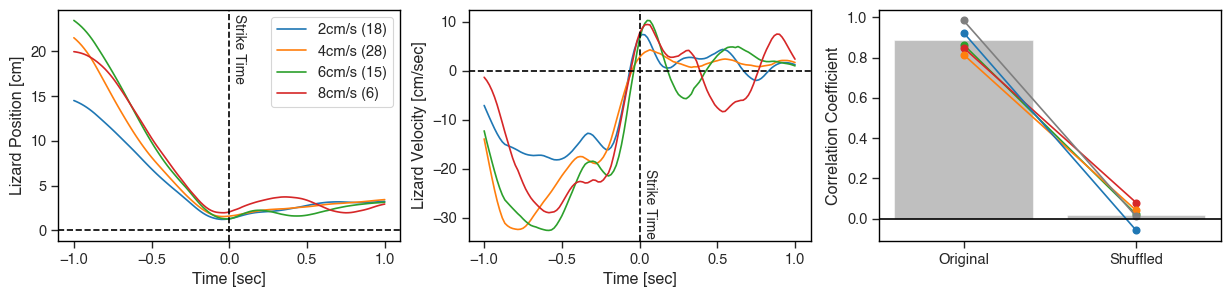

In [31]:
metrics = {'y': 'Lizard Position [cm]', 'velocity_y': 'Lizard Velocity [cm/sec]'}
circle_speed_dict = {3: 2, 6: 4, 8: 11, 11: 8}

def calc_strikes_dynamics(movement_type=None, animal_id=None, only_hits=True, is_cache=True, sec_after=2, sec_before=2, smooth_kernel=17,
                          only_first_trial_strikes=False):
    calc_speeds = (2,4,6,8)
    cache_file = Path(f'../notebooks/figures/cache/sd_res_{animal_id}_{movement_type}_{sec_after}_{sec_before}_{only_hits}_{smooth_kernel}_{only_first_trial_strikes}.pkl')
    if is_cache and cache_file.exists():
        with cache_file.open('rb') as f:
            fixed_res = pickle.load(f)
    else:
        df_ = df.copy()
        if movement_type:
            df_ = df_.query(f'movement_type=="{movement_type}"')
        screen_y_pos = 0
        if animal_id:
            df_ = df_.query(f'animal_id=="{animal_id}"')
            arena_name = df_.arena_name.iloc[0]
            screen_y_pos = SCREEN_Y_POS[arena_name]
        # if animal_id == 'PV42' and movement_type == 'circle':
        #     df_ = df_.query('time < "20230507"')
        # elif animal_id == 'PV91' and movement_type == 'circle':
        #     df_ = df_.query('time > "20230518"')
        if only_first_trial_strikes:
            df_ = df_.query('strike_num_in_trial==1')
        if only_hits:
            df_ = df_.query(f'is_hit')
        df_ = df_.reset_index(drop=True)
        res = {k: {} for k in calc_speeds}
        for i, row in df_.iterrows():
            sid = row.strike_id
            try:
                if row.movement_type == "circle" and row.bug_speed in circle_speed_dict.keys():
                    speed = circle_speed_dict[row.bug_speed]
                else:
                    speed = row.bug_speed
                if speed not in calc_speeds:
                    continue
                ld = Loader(int(sid), 'front', orm=orm, is_debug=False, sec_before=sec_before, sec_after=sec_after)
                sa = StrikeAnalyzer(ld, smooth_kernel=smooth_kernel, derivative_kernel=smooth_kernel)
                pf = sa.pose_df
                if pf is None or pf.empty:
                    continue
                t = (pf.time - pf.time.loc[sa.strike_frame_id]).dt.total_seconds()
                z = [pf[m].values - (screen_y_pos if m == 'y' else 0) for m in metrics.keys()]
                res[speed][sid] = (t, *z)
            except Exception as exc:
                print(exc)
                continue
        
        # fix different lengths of trajs
        fixed_res = {}
        metrics_labels = list(metrics.keys())
        for speed in calc_speeds:
            fixed_res[speed] = {}
            for metric in metrics_labels:
                metric_id = metrics_labels.index(metric) + 1
                lengths = [len(r[metric_id]) for r in res[speed].values()]
                mode_length = mode(lengths, keepdims=False).mode
                l = [x for x in lengths if x > mode_length - 10]
                if not l:
                    print(f'error: No valid data for metric {metric} at speed {speed}cm/sec.')
                    continue
                min_length = min(l)
                speed_res = [r for r in res[speed].values() if len(r[metric_id]) >= min_length]
                y_all = np.vstack([r[metric_id][:min_length] for r in speed_res])
                t = speed_res[0][0][:min_length]
                fixed_res[speed][metric] = (t, y_all)
        
        with cache_file.open('wb') as f:
            pickle.dump(fixed_res, f)
    return fixed_res

def filter_min_start_y(res, min_start_y):
    res_ = res.copy()
    res = {}
    for speed, d in res_.items():
        res[speed] = {}
        y_all = d['y'][1]
        mask = (y_all[:, 0] > min_start_y)
        res[speed] = {metric: (t, y_[mask, :]) for metric, (t, y_) in d.items()}
    return res

def _get_strikes_dynamics_corr(d, t):
    ranks_, speeds_ = [], []
    for speed, y in d.items():
        if len(y) == 0:
            continue
        y = -np.nanmean(y, axis=0)
        y_approach = y[(t>-.8)&(t<-.1)]
        ranks_.append(y_approach)
        speeds_.append(speed)
    ranks_ = rankdata(np.vstack(ranks_), axis=0)
    ranks_avg = ranks_.mean(axis=1)
    return np.corrcoef(speeds_, ranks_avg)[0, 1]
    
def get_strikes_dynamics_corr(res, speeds):
    ranks = {}
    t = None
    for speed in speeds:
        d = res[speed]
        t_, y = d['velocity_y']
        if y.shape[0] > 0:
            ranks[speed] = y
            if t is None:
                t = t_
    corrs = [_get_strikes_dynamics_corr(ranks, t)]
    # shuffled
    s_corrs = []
    y_ = np.vstack([y for y in ranks.values()])
    for j in range(100):
        np.random.seed(j)
        shuffled_speeds = np.random.choice(list(ranks.keys()), (y_.shape[0],))
        shuffled_ranks = {speed: y_[np.where(shuffled_speeds == speed)[0], :] for speed in ranks.keys()}
        s_corrs.append(_get_strikes_dynamics_corr(shuffled_ranks, t))
    corrs.append(np.mean(s_corrs))
    return corrs  # [original, shuffled]

def plot_single_animal_strikes_dynamics(res, axes=None, is_plot_legend=True):
    if axes is None:
        fig, axes = plt.subplots(1, len(metrics), figsize=(10, 4))
    
    lines = []
    for speed, d in res.items():
        for (metric, (t, y_all)), ax in zip(d.items(), axes):
            if y_all.shape[0] > 0:
                y = np.nanmean(y_all, axis=0)
                l = ax.plot(t, y, label=f'{speed:.0f}cm/s ({y_all.shape[0]})')
                if metric == 'velocity_y':
                    lines.append(l[0])
                    
    for ax, metric in zip(axes, metrics.keys()):
        ax.grid(False)
        ax.axvline(0, linestyle='--', color='k')
        ax.axhline(0, linestyle='--', color='k')
        y0, y1 = ax.get_ylim()
        if metric.startswith('velocity'):
            ax.text(.02, y0+0.5, 'Strike Time', rotation=270, fontsize=10, va='bottom')
        else:
            ax.text(.02, y1-0.5, 'Strike Time', rotation=270, fontsize=10, va='top')
        ax.set_ylabel(metrics[metric])
        ax.set_xlabel('Time [sec]')
        if metric == 'y' and is_plot_legend:
            ax.legend()
    return lines

def plot_strikes_dynamics(example_animal, animals_ids, movement_type='random_low_horizontal', speeds=(2,4,6,8), min_start_y=None,
                          sec_after=1, sec_before=1, only_hits=False, smooth_kernel=17, only_first_trial_strikes=True, axes=None):
    np.random.seed(11)
    if axes is None:
        fig, axes = plt.subplots(1,3, figsize=(15, 3))
    example_res = calc_strikes_dynamics(animal_id=example_animal, movement_type=movement_type, is_cache=True, sec_after=sec_after, 
                                   sec_before=sec_before, only_hits=only_hits, smooth_kernel=smooth_kernel, only_first_trial_strikes=only_first_trial_strikes)
    example_res = {speed: d for speed, d in example_res.items() if speed in speeds}
    if min_start_y:
        example_res = filter_min_start_y(example_res, min_start_y)
    plot_single_animal_strikes_dynamics(example_res, axes=axes[:2])
    
    all_corrs = []
    for animal_id in animals_ids:
        res = calc_strikes_dynamics(animal_id=animal_id, movement_type=movement_type, is_cache=True, sec_after=sec_after, 
                                    sec_before=sec_before, only_hits=only_hits, smooth_kernel=smooth_kernel, only_first_trial_strikes=only_first_trial_strikes)
        res = {speed: d for speed, d in res.items() if speed in speeds}
        if min_start_y:
            res = filter_min_start_y(res, min_start_y)
        res_counts = {speed: len(d['y'][1]) for speed, d in res.items()}
        print(f'{animal_id}: {res_counts}')
        corrs = get_strikes_dynamics_corr(res, speeds)
        axes[2].plot([0, 1], corrs, '-o', label=animal_id, color=COLORS[animal_id])
        all_corrs.append(corrs)
    
    axes[2].bar([0, 1], np.mean(np.vstack(all_corrs), axis=0), alpha=0.5, color='grey')
    axes[2].axhline(0, color='k')
    axes[2].set_ylabel('Correlation Coefficient')
    axes[2].set_xticks([0, 1])
    axes[2].set_xticklabels(['Original', 'Shuffled'])
    # fig.tight_layout()
    # fig.savefig(f'{FIGURE_PATH}/figures/strikes_dynamics.pdf')
    
    
plot_strikes_dynamics('PV91', ['PV91', 'PV80', 'PV85', 'PV42', 'PV163'], min_start_y=5, speeds=(2,4,6,8))

### Prediction Distance vs. Time in random_low_horizontal

Prediction distance regression results: r=0.65, p=0.000017
Prediction distance perm correlation results: r=0.65, p=0.000000


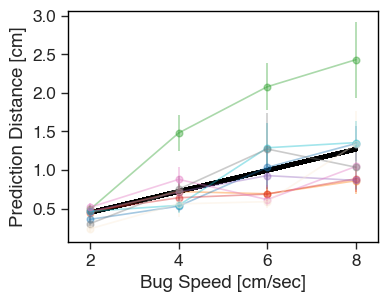

In [9]:
def permutation_test_correlation(x, y, n_permutations=1000):
    """Performs a permutation test for correlation between two variables.
  
    Args:
      x: A 1D numpy array of the first variable.
      y: A 1D numpy array of the second variable.
      n_permutations: The number of permutations to perform.
  
    Returns:
      A tuple of the following:
        * p_value: The p-value of the test.
        * observed_correlation: The observed correlation coefficient.
        * null_distribution: A 1D numpy array of the correlation coefficients from the permutation test.
    """

    # Calculate the observed correlation coefficient.
    observed_correlation, _ = pearsonr(x, y)

    # Create a list of all possible permutations of the group labels.
    permutations = np.random.permutation(np.arange(len(x)))

    # Calculate the correlation coefficient for each permutation.
    null_distribution = np.zeros(n_permutations)
    for i in range(n_permutations):
        print(permutations[i])
        null_distribution[i], _ = pearsonr(x[permutations[i]], y)

    # Calculate the p-value.
    p_value = np.sum(null_distribution >= observed_correlation) / n_permutations

    return p_value, observed_correlation, null_distribution

def perm_test_correlation(x, y, n_permutations=1000):
    #Compute ground truth correlation:
    r, _ = pearsonr(x, y)
    pS = y.copy()
    null_distribution = []
    for i in range(0, n_permutations):
        np.random.shuffle(pS)
        #Computed permuted correlations and store them in pR:
        null_distribution.append(pearsonr(pS, x)[0])

    #Significance:
    p_val = len(np.where(np.abs(null_distribution) >= np.abs(r))[0]) / n_permutations
    return r, p_val, null_distribution

def plot_pred_distance(ax, movement_type, speeds=(2, 4, 6, 8), labels_fontsize=None, hit_type='all',
                       plot_only_with_all_speeds=False, animals2drop=None, is_legend=False):
    assert hit_type in ['all', 'misses', 'hits']
    hit_type_query = ' and is_hit' if hit_type == 'hits' else ' and not is_hit' if hit_type == 'misses' else ''
    avg, lines = [], []
    for animal_id in df.animal_id.unique():
        if animals2drop and animal_id in animals2drop:
            continue
        af_ = df.query(f'animal_id=="{animal_id}" and movement_type=="{movement_type}"{hit_type_query}')[
            ['calc_speed', 'pred_distance']].copy()
        if af_.empty:
            continue
        af_['round_speed'] = af_.calc_speed.round()
        af_ = af_.query(f'round_speed in {speeds}').copy()
        g_ = af_.groupby('round_speed').pred_distance.agg(['mean', 'sem'])
        g_.dropna(inplace=True)
        avg.append(g_['mean'].to_dict())
        if not plot_only_with_all_speeds or (hit_type == 'all' and all([sp in g_.index for sp in speeds])):
            l = ax.errorbar(g_.index, g_['mean'], yerr=g_['sem'], color=COLORS[animal_id], label=animal_id, fmt='-o',
                            alpha=0.4)
            lines.append(l)

    s = np.array([(k, v) for l in avg for k, v in l.items()])
    rval, pval = plot_regression(ax, s[:, 0], s[:, 1], color='k', linewidth=3, is_legend=False)
    print(f'Prediction distance regression results: r={rval:.2f}, p={pval:f}')

    rval, pval, null_dist = perm_test_correlation(s[:, 0], s[:, 1])
    print(f'Prediction distance perm correlation results: r={rval:.2f}, p={pval:f}')
    # avg = pd.DataFrame(avg).mean()
    # ax.plot(avgm.index, avgm.values, '-o', label='Average', color='k', linewidth=3)
    ax.set_xlabel('Bug Speed [cm/sec]', fontsize=labels_fontsize)
    ax.set_ylabel('Prediction Distance [cm]', fontsize=labels_fontsize)
    ax.set_xlim([1.5, 8.5])
    if is_legend:
        ax.legend()
    return lines


_, ax = plt.subplots(1, 1, figsize=(4, 3))
plot_pred_distance(ax, 'random_low_horizontal', animals2drop=['PV95', 'PV148'], is_legend=False);

### Trajectories Model

Resampling trajectories to 26 samples from each block_speed class


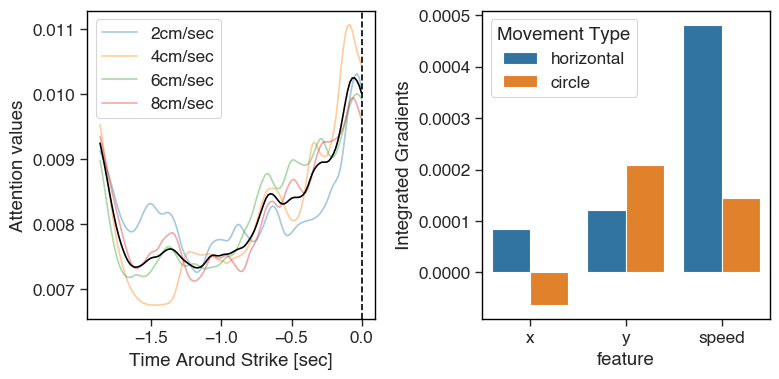

In [10]:
def plot_traj_model_results(chosen_animal='PV42', axes=None, fig=None):
    if axes is None:
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes = axes.flatten()
        
    accuracies = {}
    for animal_id, (orig_path, shuffled_path) in tqdm(traj_model_paths.items(), desc='Trajectory models'):
        accuracies[animal_id] = []
        for i, model_path in enumerate((orig_path, shuffled_path)):
            model_path = f'{TRAJ_DIR}/{model_path}'
            tj = TrajClassifier(model_path=model_path, is_debug=False)
            if animal_id == chosen_animal and i == 0:
                tj.all_data_evaluation(axes=axes[:2], is_plot_auc=False)
            
            y_true, y_pred, y_score, attns = tj.get_data_for_evaluation()
            acc = accuracy_score(y_true, y_pred)
            accuracies[animal_id].append(acc)
        # y_true_binary = label_binarize(y_true, classes=np.arange(len(tj.targets)))
        # auc = roc_auc_score(y_true_binary, y_score, average="weighted")
        # axes[2].bar(animal_id, acc, color='tab:blue')
    
    for animal_id, accs in accuracies.items():
        axes[2].plot([0, 1], accs, 'o-', color=COLORS[animal_id], label=f'{animal_id} ({accs[0]:.2f})')
    axes[2].bar(0, np.mean([v[0] for v in accuracies.values()]), color='grey', alpha=0.5)
    axes[2].bar(1, np.mean([v[1] for v in accuracies.values()]), color='grey', alpha=0.5)
    axes[2].set_xticks([0, 1])
    axes[2].set_xticklabels(['Original', 'Shuffled'])
    for ax in axes.flatten():
        ax.grid(False)
    axes[2].set_ylabel('Accuracy')
    
    if fig is not None:
        fig.tight_layout()

def plot_circle_traj_models(chosen_animal='PV42', axes=None, fig=None, att_ylims=None):
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    model_path = f'{TRAJ_DIR}/{circle_traj_models_path[chosen_animal][0]}'
    tj = TrajClassifier(model_path=model_path, is_debug=False)
    y_true, y_pred, y_score, attns = tj.get_data_for_evaluation()
    tj.plot_attention(axes[0], attns)
    if att_ylims is not None:
        axes[0].set_ylim(att_ylims)
    
    # comparison of feature importance
    animal_imps = pd.read_csv(f'{FIGURE_PATH}/cache/integrated_gradients_PV42_best_5.csv', index_col=0)
    sns.barplot(data=animal_imps, x='feature', y='value', hue='Movement Type', ax=axes[1])
    axes[1].set_ylabel('Integrated Gradients')
    
    if fig is not None:
        fig.tight_layout()
    
# plot_traj_model_results()
plot_circle_traj_models()

### Projected Strikes Plots

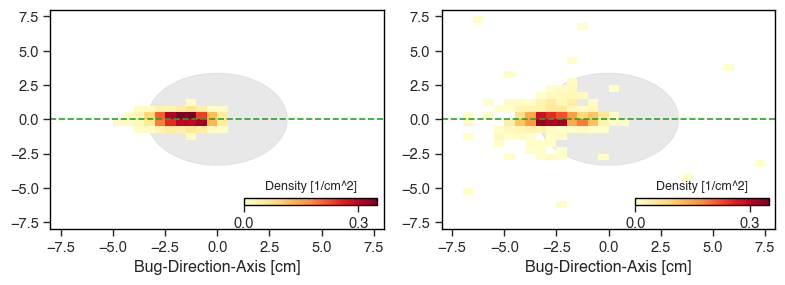

In [40]:
max_proj_x, max_proj_y = 8, 8

def plot_projected(ax, af, is_legend=True):
    # af = af.query(f'-{max_proj_x} <= proj_bug_x <= {max_proj_x}')
    ax.add_patch(plt.Circle((0, 0), af.bug_size.mean() * SCREEN_PIX_CM['reptilearn4'], color='lightgrey', alpha=0.5))
    
    cm = plt.cm.get_cmap('Blues')
    ax.axhline(0, linestyle='--', color='tab:green')
    bins = np.arange(-8, 8, 0.5)
    kwargs = dict(cbar=False, pthresh=0, pmax=0.5, stat='density', cmap='Blues', bins=(bins, bins))
    # if is_legend:
    #     cax = ax.inset_axes([1.05, 0.1, 0.03, 0.8])
    #     kwargs['cbar_ax'] = cax
    #     kwargs['cbar'] = True
        
    _, _, _, h = ax.hist2d(af.proj_strike_x_cm, af.proj_strike_y_cm, bins=(bins, bins), density=True, 
                            cmin=0.005, vmax=0.35, vmin=0, cmap='YlOrRd')
    if is_legend:
        cax = ax.inset_axes([0.58, 0.11, 0.4, 0.03])
        cbar = plt.colorbar(h, ax=ax, cax=cax, ticks=[0, 0.3], orientation='horizontal')
        cbar.ax.get_yaxis().labelpad = 15
        cbar.ax.set_title('Density [1/cm^2]', fontsize=9)
    
    # sns.histplot(data=af, x='proj_strike_x_cm', y='proj_strike_y_cm', ax=ax, **kwargs)
    
    # sc = ax.scatter(af.proj_strike_x, af.proj_strike_y, c=af.proj_bug_x, cmap=cm)
    # if is_legend:
    #     cax = ax.inset_axes([1.05, 0.1, 0.03, 0.8])
    #     cbar = plt.colorbar(sc, ax=ax, cax=cax, ticks=[-200, -400], orientation="vertical")
    #     cbar.ax.set_yticklabels([200, 400])
    #     cbar.ax.get_yaxis().labelpad = 15
    #     cbar.ax.set_ylabel('Prediction Distance', rotation=270, fontsize=10)
    ax.set_xlim([-max_proj_x, max_proj_x])
    ax.set_ylim([-max_proj_y, max_proj_y])
    ax.set_xlabel('Bug-Direction-Axis [cm]')

def plot_projected_histogram(ax, af, is_plot_legend=True):
    sns.histplot(data=af, x='proj_strike_y', hue='movement_type', ax=ax)
    ax.set_xlim([-300, 300])
    ax.grid(False)
    ax.set_xlabel('Projected Y-values')
    if not is_plot_legend:
        ax.get_legend().remove()
        
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
plot_projected(axes[0], df.query(f'movement_type=="random_low_horizontal"'), is_legend=True)
plot_projected(axes[1], df.query(f'movement_type=="circle"'), is_legend=True)
fig.tight_layout()

17.641064752326553 34.513641185860806
6.6978 45.8964


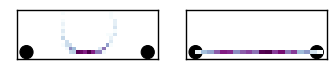

In [12]:
def plot_hist_for_strikes_on_screen(movement_type, arena, ax=None):
    hole_y = 18
    xf = df.query(f'movement_type=="{movement_type}" and arena_name=="{arena}"').copy()
    xf[['bug_x', 'bug_y']] = xf[['bug_x', 'bug_y']].applymap(lambda x: x * SCREEN_PIX_CM[arena])
    if ax is None:
        ax = plt.subplot()
    if movement_type == 'random_low_horizontal':
        xf['bug_y'] = hole_y
        bins = (20, 1)
    elif movement_type == 'circle':
        bins = (15, 15)
        xf['center_dist'] = xf[['bug_x', 'bug_y']].apply(lambda row: distance.euclidean(row, (26, 11)), axis=1)
        xf = xf.query('center_dist<9')
        # xf = xf.query('bug_y<19 and 15<bug_x<35')    
        # circ = mpl.patches.Circle((26, 11), radius=7.5, fc='none', ec='k')
        # ax.add_patch(circ)
    
    # plot holes
    for hole_x in [7, 44]:
        circ = mpl.patches.Circle((hole_x, hole_y), radius=2, fc='k', ec='k')
        ax.add_patch(circ)
    # sns.histplot(data=xf, x='bug_x', y='bug_y', ax=ax, bins=bins, color='tab:green', thresh=1)
    ax.hist2d(xf.bug_x, xf.bug_y, bins=bins, cmap='BuPu', cmin=1)
    print(xf.bug_x.min(), xf.bug_x.max())
    ax.set_xlim([4, 47])
    ax.set_ylim([5, hole_y+2.2])
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal',adjustable='box')
    # ax.axis('equal')

fig, axes = plt.subplots(1, 2, figsize=(4, 2))
plot_hist_for_strikes_on_screen('circle', 'reptilearn4', ax=axes[0])
plot_hist_for_strikes_on_screen('random_low_horizontal', 'reptilearn4', ax=axes[1])

17.641064752326553 34.513641185860806


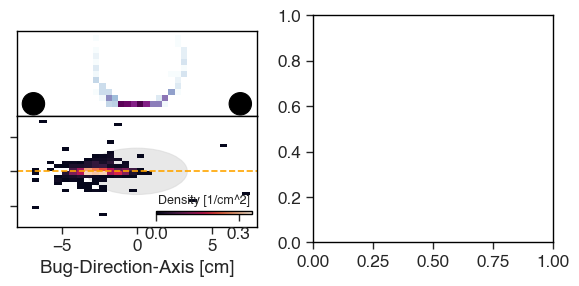

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_all_strikes_hists(ax, movement_type):
    divider = make_axes_locatable(ax)
    ax2 = divider.append_axes("bottom", size="130%", pad=0)
    fig1 = ax.get_figure()
    fig1.add_axes(ax2)
    ax2.yaxis.set_tick_params(labelleft=False)
    
    plot_hist_for_strikes_on_screen(movement_type, 'reptilearn4', ax=ax)
    plot_projected(ax2, df.query(f'movement_type=="{movement_type}"'), is_legend=True)
    
    
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
plot_all_strikes_hists(axes[0], 'circle')
fig.tight_layout()

### Circle Analysis

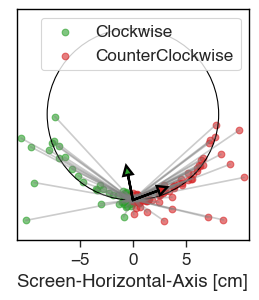

In [14]:
def rotate(vector, theta, rotation_around=None) -> np.ndarray:
    """
    reference: https://en.wikipedia.org/wiki/Rotation_matrix#In_two_dimensions
    :param vector: list of length 2 OR
                   list of list where inner list has size 2 OR
                   1D numpy array of length 2 OR
                   2D numpy array of size (number of points, 2)
    :param theta: rotation angle in radian (+ve value of anti-clockwise rotation)
    :param rotation_around: "vector" will be rotated around this point,
                    otherwise [0, 0] will be considered as rotation axis
    :return: rotated "vector" about "theta" degree around rotation
             axis "rotation_around" numpy array
    """
    vector = np.array(vector)
    if vector.ndim == 1:
        vector = vector[np.newaxis, :]

    if rotation_around is not None:
        vector = vector - rotation_around

    vector = vector.T
    # theta = np.radians(theta)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    output: np.ndarray = (rotation_matrix @ vector).T
    if rotation_around is not None:
        output = output + rotation_around

    return output.squeeze()

def get_tang_pos(x, y, c_x, c_y, bug_speed, dt, is_clockwise):
    radius_vec = np.array([x-c_x, y-c_y])
    z = 1 if is_clockwise else -1
    tang_vec = np.cross(np.append(radius_vec, 0), [0, 0, z])
    ratio = tang_vec[0] / tang_vec[1]
    v1 = bug_speed * np.sqrt(ratio**2/(1+ratio**2))
    v2 = bug_speed * np.sqrt(1/(1 + ratio**2))
    return x + dt*v1, y + dt*v2

def get_circle_df(is_cache=True):
    cache_path = Path(f'{FIGURE_PATH}/cache/circle_df.pkl')
    if is_cache and cache_path.exists():
        res = pd.read_parquet(cache_path)
    else:
        df_ = df.query('movement_type=="circle"')
        res = []
        for i, row in tqdm(df_.iterrows(), total=len(df_)):
            try:
                ld = Loader(int(row.strike_id), 'front', orm=orm, sec_before=5, sec_after=5, is_debug=False)
                sa = StrikeAnalyzer(ld, is_y_pd=False)
                
                pose_df = sa.pose_df.reset_index().rename(columns={'index': 'frame_id'})
                pose_df['datetime'] = pd.to_datetime(pose_df['time'], unit='s')
                                
                bug_traj = ld.traj_df
                bug_traj = bug_traj.rename(columns={'x': 'bug_x', 'y': 'bug_y'})
                bug_traj['time'] = pd.to_datetime(bug_traj['time']).dt.tz_localize(None)
                bug_traj = bug_traj.sort_values(by='time')
                                
                pose_df = pd.merge_asof(left=pose_df, right=bug_traj, left_on='datetime', right_on='time', 
                                        direction='nearest', tolerance=pd.Timedelta('100 ms'))
                
                pose_df = pose_df.set_index('frame_id')
                lp = pose_df.loc[sa.leap_frame]
                dt = (sa.strike_frame_id - sa.leap_frame) / 60
                res.append({'strike_id': row.strike_id, 'animal_id': row.animal_id, 'is_hit': row.is_hit,
                            'bug_x': lp.bug_x, 'bug_y': lp.bug_y, 'strike_x': sa.strike_position[0], 
                            'strike_y': sa.strike_position[1], 'dt': dt, 'bug_speed': sa.bug_speed})
            except Exception:
                continue
        
        res = pd.DataFrame(res)
        res.to_parquet(cache_path)
    return res

def init_circle(single_animal='PV91', animal_ids=None):
    cdf = get_circle_df()
    if animal_ids is not None:
        cdf = cdf.query(f'animal_id in {animal_ids}').copy()
    for c in ['rot_bug_pos', 'rot_strike', 'rot_tang_pos']:
        cdf[c] = None
    
    new_cdfs = []
    for animal_id in cdf.animal_id.unique():
        cdf_ = cdf.query(f'animal_id=="{animal_id}"').copy()
        c_x, c_y, c_r = fit_circle(cdf_.bug_x.values, cdf_.bug_y.values)
        dr_func = lambda pos: distance.euclidean(pos, (c_x, c_y))
        for c in ['c_x', 'c_y', 'c_r']:
            cdf_[c] = locals()[c]
        cdf_['dist_r'] = (cdf_[['bug_x', 'bug_y']].apply(dr_func, axis=1) - c_r).abs()
        idx2remove = cdf_.query('dist_r > 10').index.tolist()
        cdf_.drop(index=idx2remove, inplace=True)
        
        for i, row in cdf_.iterrows():
            bug_point = (row.bug_x - c_x, row.bug_y - c_y)
            strike_point = (row.strike_x - c_x, row.strike_y - c_y)
            bug_estim_th = np.arctan2(bug_point[1], bug_point[0])
            strike_estim_th = np.arctan2(strike_point[1], strike_point[0])
            rot_angle = (np.pi / 2) - bug_estim_th
            is_clockwise = strike_estim_th > bug_estim_th
            cdf_.loc[i, 'is_clockwise'] = is_clockwise
            cdf_.at[i, 'rot_bug_pos'] = rotate(bug_point, rot_angle).tolist()
            cdf_.at[i, 'rot_strike'] = rotate(strike_point, rot_angle).tolist()
            tang_pos = get_tang_pos(row.bug_x, row.bug_y, c_x, c_y, row.bug_speed, row['dt'], is_clockwise)
            tang_pos = (tang_pos[0] - c_x, tang_pos[1] - c_y)
            cdf_.at[i, 'rot_tang_pos'] = rotate(tang_pos, rot_angle).tolist()
        new_cdfs.append(cdf_)
        
    cdf = pd.concat(new_cdfs)
    single_df = cdf.query(f'animal_id=="{single_animal}"')
    C_X, C_Y, R = fit_circle(single_df.bug_x.values, single_df.bug_y.values)
    return cdf, C_X, C_Y, R

def circle_plot_hist(animal_ids, ax=None):
    cdf, c_x, c_y, c_r = init_circle(animal_ids=animal_ids)
    dr_func = lambda pos: distance.euclidean(pos, (c_x, c_y))
    cdf['strike_dist_r'] = cdf[['strike_x', 'strike_y']].apply(dr_func, axis=1)
    if ax is None:
        ax = plt.subplot()
    x = cdf.strike_dist_r.values - c_r
    sns.histplot(x=x, ax=ax)#, bins=np.arange(100, 500, 3))
    ax.axvline(cdf.strike_dist_r.median()-c_r, linestyle='--', color='tab:orange', label='Median')
    ax.axvline(0, linestyle='--', color='r', label='Bug-Trajectory Radius')
    # ax.legend()
    ax.set_xlabel(r'$\rho$ - Distance from circle center [pixels]')
    ax.set_xlim([-50, 50])

def circle_plot_proj(single_animal, ax=None):
    arena = 'msi-regev' if single_animal in ['PV42', 'PV80', 'PV85'] else 'reptilearn4'
    ylim, xlim = 400 * SCREEN_PIX_CM[arena], 400 * SCREEN_PIX_CM[arena]
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    
    cdf, C_X, C_Y, R = init_circle(single_animal, [single_animal])
    R = R * SCREEN_PIX_CM[arena]
    for i, (title, color) in enumerate(zip(['Clockwise', 'CounterClockwise'], ['tab:green', 'tab:red'])):
        is_clockwise = title == 'Clockwise'
        single_df = cdf.query(f'animal_id=="{single_animal}" and is_clockwise=={is_clockwise}').reset_index().copy()
        for c in ['rot_strike', 'rot_bug_pos']:
            single_df[c] = single_df[c].map(lambda l: [x * SCREEN_PIX_CM[arena] for x in l])
        for j, row in single_df.iterrows():
            if (row.rot_strike[1] < 0) or (row.rot_strike[1] > ylim) or (np.abs(row.rot_strike[0]) > xlim):
                continue
            if (is_clockwise and row.rot_strike[0] > 1) or (not is_clockwise and row.rot_strike[0] < -1):
                continue
            ax.scatter(*row.rot_strike, color=color, alpha=0.6, label=title if j==0 else None)
            ax.plot([row.rot_bug_pos[0], row.rot_strike[0]], 
                    [row.rot_bug_pos[1], row.rot_strike[1]], color='grey', alpha=0.4)
        
        x_mean = single_df.rot_strike.map(lambda x: x[0]).mean()
        y_mean = single_df.rot_strike.map(lambda x: x[1]).mean()
        ax.arrow(0, R, x_mean, y_mean-R, color=color, length_includes_head=False,
                      head_width=0.9, head_length=0.9, linewidth=1.7, zorder=20, ec='k')
    
    circ = mpl.patches.Circle((0, 0), radius=R, fc='none', ec='k')
    ax.add_patch(circ)
    ax.axis('equal')
    # ax.set_ylim([2, ylim/4])
    ax.set_xlim([-xlim, xlim])
    ax.invert_yaxis()
    ax.set_xticks([-5, 0, 5])
    ax.set_xlabel('Screen-Horizontal-Axis [cm]')
    ax.set_yticks([])
    ax.legend()

def circle_stats(animal_ids=None):
    cdf, _, _, _ = init_circle(animal_ids=animal_ids)
    
    def statistic_mean_diff(x, y, axis):
        return np.mean(x, axis=axis) - np.mean(y, axis=axis)
    
    rho_strike = cdf.rot_strike.map(lambda pos: np.sqrt(pos[0]**2 + pos[1]**2))
    rho_tang = cdf.rot_tang_pos.map(lambda pos: np.sqrt(pos[0]**2 + pos[1]**2))
    res = permutation_test((rho_strike, rho_tang), statistic_mean_diff, vectorized=True)
    plt.hist(res.null_distribution)
    plt.title(f'Statistic={res.statistic:.1f}, p-value={res.pvalue:.3f}')
    
# circle_plot_hist(['PV91', 'PV99'])
circle_plot_proj('PV91')
# circle_stats(animal_ids=['PV91'])

### Plot figure 1

PV91: {2: 18, 4: 28, 6: 15, 8: 6}
PV80: {2: 7, 4: 10, 6: 13, 8: 13}
PV85: {2: 5, 4: 7, 6: 12, 8: 7}
PV42: {2: 8, 4: 13, 6: 9, 8: 11}
PV163: {2: 3, 4: 17, 6: 4, 8: 16}
Prediction distance regression results: r=0.65, p=0.000017
Prediction distance perm correlation results: r=0.65, p=0.000000


Trajectory models:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling trajectories to 26 samples from each block_speed class


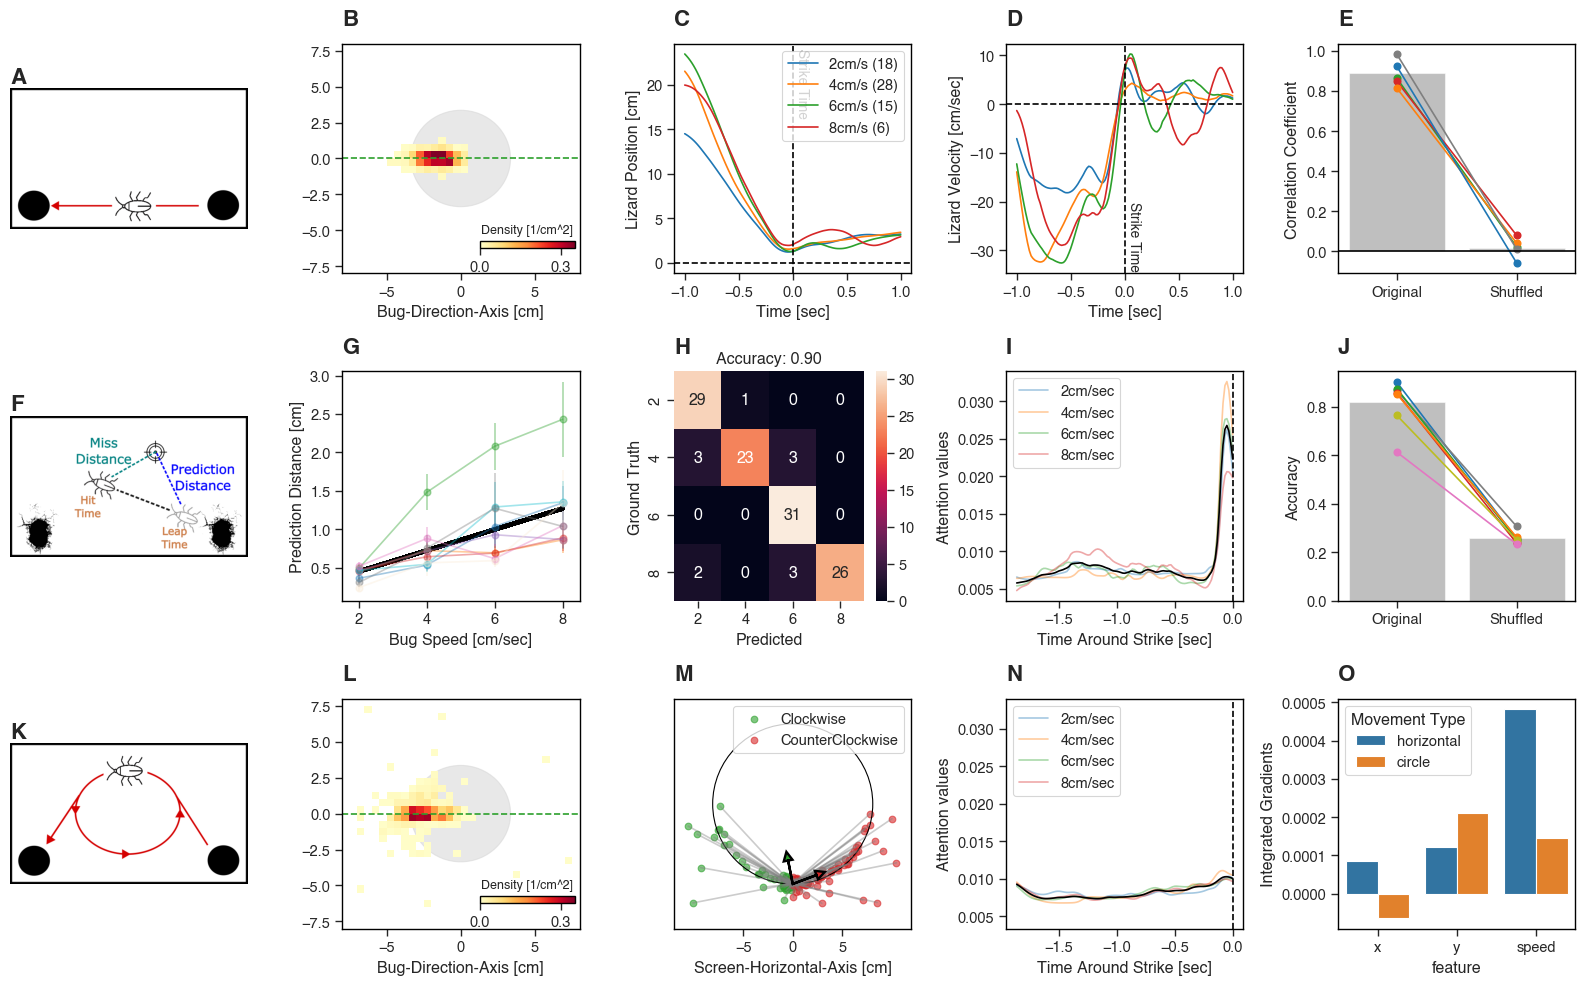

In [41]:
def plot_figure1():
    fig, axes = plt.subplots(3, 5, figsize=(16, 10))
    sns.set_context('paper', font_scale=1.2)
    
    img = cv2.imread(f'{FIGURE_PATH}/assets/low_horizontal.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0, 0].imshow(img)
    axes[0, 0].axis('off')
    plot_projected(axes[0, 1], df.query(f'movement_type=="random_low_horizontal"'), is_legend=True)
    # plot_all_strikes_hists(axes[0, 1], 'random_low_horizontal')
    
    plot_strikes_dynamics('PV91', ['PV91', 'PV80', 'PV85', 'PV42', 'PV163'], min_start_y=5, speeds=(2,4,6,8), axes=axes[0, 2:])
    
    img = cv2.imread(f'{FIGURE_PATH}/assets/explain_prediction_distance.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[1, 0].imshow(img)
    axes[1, 0].axis('off')
    plot_pred_distance(axes[1, 1], 'random_low_horizontal', speeds=(2,4,6,8), labels_fontsize=None,
                       plot_only_with_all_speeds=True, animals2drop=['PV95', 'PV148'])
    
    plot_traj_model_results(axes=axes[1, 2:])
    att_ylims = axes[1, 3].get_ylim()
    
    img = cv2.imread(f'{FIGURE_PATH}/assets/circle.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[2, 0].imshow(img)
    axes[2, 0].axis('off')
    plot_projected(axes[2, 1], df.query(f'movement_type=="circle"'), is_legend=True)
    # plot_all_strikes_hists(axes[2, 1], 'circle')
    circle_plot_proj('PV91', ax=axes[2, 2])
    
    plot_circle_traj_models(axes=axes[2, 3:], att_ylims=att_ylims)
    
    for ax, letter in zip(axes.flatten(), ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']):
        add_ax_letter(ax, letter, x=0)

    fig.tight_layout()
    fig.savefig(f'{FIGURE_PATH}/figures/figure1.pdf')
    fig.savefig(f'{FIGURE_PATH}/figures/figure1.png')


plot_figure1()

# Figure 2 - Non-visually guided predictive behaviors

### Jump-Up

In [ ]:
def get_time_from_prev_jump(ld):
    """return time in seconds from the closest jump before strike"""
    dt = np.nan
    try:
        traj = ld.traj_df.copy()
        jump_idx = np.where(traj.y.diff().abs() > 40)[0]

        if len(jump_idx) > 0:
            jump_idx_ = jump_idx[jump_idx < ld.bug_traj_strike_id]
            if len(jump_idx_):
                closest_jump_before = jump_idx_[-1]
                dt = (ld.traj_df.time[ld.bug_traj_strike_id] - ld.traj_df.time[closest_jump_before]).total_seconds()
    except Exception as exc:
        print(f'{ld}: {exc}')
    return dt


def calc_jumps(is_cache=True):
    cache_path = Path(f'{FIGURE_PATH}/cache/jump_up.pkl')
    if is_cache and cache_path.exists():
        with cache_path.open('rb') as f:
            jdf = pickle.load(f)
    else:
        jdf = df.query('movement_type in ["jump_up","jump_up_old","accelerate"] and time>="2023-05-25"').copy()
        for c in ['y_pred_distance', 'time_from_jump', 'bug_pos_leap_x', 'bug_pos_leap_y', 'strike_pos_x', 'strike_pos_y']:
            jdf[c] = None
        for i, row in tqdm(jdf.iterrows(), total=len(jdf)):
            try:
                ld = Loader(row.strike_id, 'front', orm=orm, is_debug=False, is_use_db=True)
                sa = StrikeAnalyzer(ld, is_y_pd=True)
                jdf.loc[i, 'y_pred_distance'] = sa.prediction_distance
                jdf.loc[i, 'time_from_jump'] = get_time_from_prev_jump(ld)
                jdf.loc[i, 'bug_pos_leap_x'] = sa.bug_pos_at_leap[0]
                jdf.loc[i, 'bug_pos_leap_y'] = sa.bug_pos_at_leap[1]
                jdf.loc[i, 'strike_pos_x'] = sa.strike_position[0]
                jdf.loc[i, 'strike_pos_y'] = sa.strike_position[1]
            except Exception as exc:
                continue
        jdf['miss_distance_y'] = jdf.bug_pos_leap_y - jdf.strike_pos_y
        with cache_path.open('wb') as f:
            pickle.dump(jdf, f)
                
    return jdf


def plot_jump_up_pd_misses(jdf, axes=None):
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
    animals_ids = ['PV91', 'PV95', 'PV163']
    for animal_id in animals_ids:
        jdf_ = jdf.query(f'0.005 <= time_from_jump <= 0.4 and animal_id=="{animal_id}"').sort_values(by='time')
        if jdf_.empty:
            continue
        block_ids, pds, misses = [], [], []
        for block_id, x in jdf_.groupby('block_id'):
            pds.append(x.y_pred_distance.mean())  #.abs()
            misses.append(x.miss_distance.mean())
            block_ids.append(block_id)
        block_ids = [b - block_ids[0] for b in block_ids]
        misses = [pixels2cm(x) for x in misses]
        # print(pd.DataFrame({'block_id': block_ids, 'y_pred_distance': pds,'miss_distance': misses}))

        plot_regression(axes[0], np.array(block_ids), np.array(pds), color=COLORS[animal_id], prefix=animal_id)
        sns.scatterplot(x=block_ids, y=pds, ax=axes[0], color=COLORS[animal_id])
        sns.move_legend(axes[0], "lower center", bbox_to_anchor=(0.5, 1))
        axes[0].set_xlabel('Blocks')
        axes[0].set_ylabel(r'$\Delta$Y-Prediction-Distance [cm]')
        axes[0].grid(False)
        
        plot_regression(axes[1], np.array(block_ids), np.array(misses), color=COLORS[animal_id], prefix=animal_id)
        sns.scatterplot(x=block_ids, y=misses, ax=axes[1], color=COLORS[animal_id])
        sns.move_legend(axes[1], "lower center", bbox_to_anchor=(0.5, 1))
        axes[1].set_xlabel('Blocks')
        axes[1].set_ylabel('Misses [cm]')
        axes[1].grid(False)
        

@cached_artifact
def tongue_out_verification(threshold=0.7):
    strike_ids = [409, 411, 414, 415, 424]
    ta = TongueOutAnalyzer()
    res = []
    for sid in strike_ids:
        ld = Loader(int(sid), 'front', is_use_db=False, sec_before=2, sec_after=2)
        sa = StrikeAnalyzer(ld)
        t = (sa.pose_df.time - sa.pose_df.time.loc[sa.strike_frame_id]).dt.total_seconds()
        y = sa.pose_df.y
        first_tongue = None
        for frame_id, frame in ld.gen_frames_around_strike():
            label, prob = ta.tr.predict(frame)
            is_tongue = label == TONGUE_CLASS and prob >= threshold
            if is_tongue:
                first_tongue = frame_id
                break
        
        if first_tongue is None:
            print(f'unable to find first tongue for strike_id: {sid}')
            continue
        app_jump_id = first_tongue + round(60*0.3)
        res.append({'t': t, 'y': y, 'first_tongue': first_tongue, 'app_jump_id': app_jump_id})
    return res
    

def plot_tongue_verification(ax, res):
    ax.axvline(0, linestyle='--', color='tab:red')
    for r in res:
        t, y = r['t'], r['y']
        ax.plot(t, y, color='k', alpha=0.6)
        ax.scatter(t[r['first_tongue']], y[r['first_tongue']], color='tab:green')
        
        ax.scatter(t[r['app_jump_id']], y[r['app_jump_id']], color='tab:purple')
        ax.set_xlabel('Time around strike [sec]')
        ax.set_ylabel("Arena's Y-axis [cm]")

In [ ]:
jf = calc_jumps(is_cache=False)

In [ ]:
acf = jf.query('movement_type=="accelerate"').copy()
acf['pred_distance_x'] = (acf.strike_pos_x - acf.bug_pos_leap_x).abs() * SCREEN_PIX_CM['reptilearn4']
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for animal_id, idx in acf.groupby('animal_id').groups.items():
    acf_ = acf.loc[idx].copy().sort_values(by='time')
    mean_block = acf_.groupby('block_id').agg({'pred_distance_x': 'mean', 'miss_distance': 'mean'}).sort_index().reset_index()
    mean_block = mean_block.rename(columns={'index': 'block_id'})
    mean_block['block_id'] = mean_block.block_id - mean_block.block_id.iloc[0]
    mean_block = mean_block.query('block_id<80')
    # if animal_id == 'PV163':
    #     mean_block = mean_block.query('pred_distance_x<30')
    # elif animal_id == 'PV91':
    #     mean_block = mean_block.query('pred_distance_x>20')
    if animal_id == 'PV52':
        mean_block = mean_block.query('0.7<pred_distance_x<4')
    else:
        mean_block = mean_block.query('0.8<pred_distance_x<4')
    # acf_['time0'] = (acf_.time - acf_.time.iloc[0]).dt.total_seconds()
    axes[0].scatter(mean_block.block_id, mean_block.pred_distance_x, color=COLORS[animal_id])
    plot_regression(axes[0], mean_block.block_id.values, mean_block.pred_distance_x.values, color=COLORS[animal_id])

    # mean_block = mean_block.query('miss_distance<80')
    axes[1].scatter(mean_block.block_id, mean_block.miss_distance, color=COLORS[animal_id])
    plot_regression(axes[1], mean_block.block_id.values, mean_block.miss_distance.values, color=COLORS[animal_id])
    # new_acf.append(acf_)

# acf = pd.concat(new_acf)


# sns.scatterplot(data=acf, x='time0', y='pred_distance_x', hue='animal_id')
# plt.ylim([-100, 100])
axes[0].set_xlabel('Block Number')
axes[0].set_ylabel('Horizontal Prediction Distance [cm]')
axes[0].legend()

In [ ]:
ax = plt.subplot()
max_vals = 1000
for animal_id in ['PV91', 'PV95', 'PV163']:
    # and y_pred_distance<(0-1)
    #  and 0.005 <= time_from_jump <= 0.4
    jf_ = jf.query(f'animal_id=="{animal_id}" and y_pred_distance==y_pred_distance').sort_values(by='time').copy()  #  and (0-5) < y_pred_distance<(0-1)
    # print(jf_)
    # jf_['y_pred_distance'] = jf_.y_pred_distance.abs()
    # jf_ = jf_.query('y_pred_distance>1')
    y = jf_.y_pred_distance.values.astype(float)[:max_vals]
    # x = jf_.time_from_jump.values.astype(float)[-max_vals:]
    bug_x = (jf_.strike_id - jf_.strike_id.iloc[0]).values.astype(float)[:max_vals]
    # x = np.arange(len(y))
    sns.scatterplot(x=bug_x, y=y, c=COLORS[animal_id], alpha=0.4)
    plot_regression(ax, bug_x, y, color=COLORS[animal_id], prefix=animal_id, linewidth=3)

### Occlusions

In [129]:
def calc_exit_hole(af):
    bug_x = af.bug_x.dropna()
    if len(bug_x) == 0:
        return 'unknown'
    return 'right' if np.sign(bug_x.iloc[10] - bug_x.iloc[0]) == 1 else 'left'

def calc_angle_between_lines(a1, b1, a2, b2):
    return np.arccos((a1*a2 + b1*b2) / (np.sqrt(a1**2 + b1**2) * np.sqrt(a2**2 + b2**2)))

def calc_gaze_deviation_angle(ang, bug_y, bug_x, x, y):
    m_exp = (y - bug_y) / (x - bug_x)
    if ang == np.pi/2:
        x_obs = x
        dev_ang = np.math.degrees(calc_angle_between_lines(1, 0, m_exp, -1))
    else:
        m_obs = np.tan(np.pi-ang)
        n_obs = y - m_obs*x
        x_obs = (bug_y - n_obs)/m_obs
        a = distance.euclidean((bug_x, bug_y), (x, y))
        b = distance.euclidean((x_obs, bug_y), (x, y))
        c = np.abs(x_obs - bug_x)
        dev_ang = np.arccos((a**2 + b**2 - c**2) / (2*a*b))
        if ang > np.pi:
            dev_ang = np.pi - dev_ang
        dev_ang = np.math.degrees(dev_ang)

    sgn = np.sign(x_obs - bug_x) if ang < np.pi else -np.sign(x_obs - bug_x)
    return sgn * dev_ang, x_obs

def get_arena(animal_id):
    return 'msi-regev' if animal_id in ['PV80', 'PV42', 'PV85'] else 'reptilearn4'

def add_dev_angle_to_dataframe(af, animal_id):
    dev_angs, x_obss = [], []
    bug_y = SCREEN_Y_POS[get_arena(animal_id)]
    for j, row in af.iterrows():
        if np.isnan(row.bug_x_cm) or np.isnan(row.nose_x) or any(row[f'{bp}_prob'] < 0.8 for bp in ['nose', 'right_ear', 'left_ear']):
            dev_ang, x_obs = np.nan, np.nan
        else:
            dev_ang, x_obs = calc_gaze_deviation_angle(row.angle, bug_y, row.bug_x_cm, row.nose_x, row.nose_y)
        dev_angs.append(dev_ang)
        x_obss.append(x_obs)
    af['dev_angle'] = dev_angs
    af['x_obs'] = x_obss
    return af

def calc_strike_frame(pose_df, orig_strike_frame, delta=20):
    y = pose_df.loc[orig_strike_frame-delta:orig_strike_frame+1, 'nose_y']
    peaks_idx, _ = find_peaks(-y.values, height=-2, distance=10)
    if len(peaks_idx) == 0:
        return orig_strike_frame
    min_peak_id = y[y.index[peaks_idx]].idxmin()
    return min_peak_id

    # for strike_time in strikes_times:
    #     orig_strike_frame = (pose_df.datetime - strike_time).dt.total_seconds().abs().idxmin()
    #     strike_id = pose_df.loc[orig_strike_frame, 'strike_id']
    #     y = pose_df.loc[orig_strike_frame-delta:orig_strike_frame+delta+1, 'nose_y']
    #     peaks_idx, _ = find_peaks(-y.values, height=0, distance=10)
    #     max_peak_id = y[y.index[peaks_idx]].idxmin()
    #     plt.plot([orig_strike_frame, max_peak_id], [y[orig_strike_frame], y[max_peak_id]], '-o', color='tab:orange')

    # plt.scatter(orig_strike_frame, y[orig_strike_frame], color='tab:cyan')
    # plt.scatter(y.index[peaks_idx], y[y.index[peaks_idx]], color='tab:orange')
    # plt.scatter(max_peak_id, y[max_peak_id], color='tab:red')
    # plt.title(f'Strike {strike_id}')
    # plt.show()

def get_pose_df(blk, animal_id):
    dlc = DLCArenaPose('front', orm=orm)
    pose_df = []
    for vid in blk.videos:
        try:
            pdf_ = dlc.load(video_db_id=vid.id)
            pose_df.append(pdf_)
        except Exception:
            pass
    if not pose_df:
        return
    pose_df = pd.concat(pose_df)
    pose_df.columns = ['_'.join(c) if c[1] else c[0] for c in pose_df.columns]
    if 'bug_x_cm' not in pose_df.columns:
        return
    # fix for bug_x
    arena = get_arena(animal_id)
    pose_df['bug_x_cm'] = (pose_df['bug_x'] * SCREEN_PIX_CM[arena]) + SCREEN_START_X[arena]
        
    pose_df['datetime'] = pd.to_datetime(pose_df['time'], unit='s')
    pose_df = add_dev_angle_to_dataframe(pose_df, animal_id)
    return pose_df

def angles_summary(animal_ids, movement_types=None, is_cache=True, is_trial_with_strikes=False, only_exit_hole=None):
    cache_path = Path(f'{FIGURE_PATH}/cache/angles_summary_{animal_ids}_{movement_types}_only_strikes_{is_trial_with_strikes}.pkl')
    if is_cache and cache_path.exists():
        with cache_path.open('rb') as f:
            d = pickle.load(f)
            pose_dict, tr_df = d['pose_dict'], d['tr_df']
    else:
        with orm.session() as s:
            filters = [
                Experiment.arena.in_(['reptilearn4', 'msi-regev']),
                Experiment.animal_id.in_(animal_ids),
                Experiment.animal_id.startswith('PV'),
                Experiment.start_time > '2023-04-18'
            ]
            if movement_types is not None:
                filters.append(Block.movement_type.in_(movement_types))
            orm_res = s.query(Block, Experiment).join(Experiment, Experiment.id == Block.experiment_id).filter(*filters).all()
            pose_dict, tr_df, trials_valid = {}, [], {}
            for blk, exp in tqdm(orm_res):
                animal_id = exp.animal_id
                pose_df = get_pose_df(blk, animal_id)
                if pose_df is None:
                    continue
                bug_trajs = []
                for tr in blk.trials:
                    if is_trial_with_strikes and len(tr.strikes) < 1:
                        continue

                    if tr.bug_trajectory:
                        bug_trajs = pd.DataFrame(tr.bug_trajectory)
                        bug_trajs = bug_trajs.rename(columns={'x': 'bug_x', 'y': 'bug_y'})
                        bug_trajs['datetime'] = pd.to_datetime(bug_trajs['time']).dt.tz_localize(None)
                        bug_trajs = bug_trajs.sort_values(by='datetime')
                        exit_hole = calc_exit_hole(bug_trajs)
                        if only_exit_hole and only_exit_hole != exit_hole:
                            continue

                        start_time = bug_trajs.iloc[0].datetime - timedelta(seconds=1)
                        end_time = bug_trajs.iloc[-1].datetime + timedelta(seconds=1)
                        trial_pose_df = pose_df[(pose_df.datetime > start_time) & (pose_df.datetime <= end_time)].copy()
                        if len(trial_pose_df) == 0:
                            continue
                        trial_pose_df['strike_id'] = np.nan
                        trials_valid[int(tr.id)] = [(trial_pose_df.datetime-trial_pose_df.datetime.iloc[0]).dt.total_seconds(), trial_pose_df.nose_y]
                        tr_df.append({'trial_id': int(tr.id), 'exit_hole': exit_hole, 'animal_id': exp.animal_id, 'movement_type': blk.movement_type})
                        d_ = pose_dict.setdefault(animal_id, {})
                        d_[tr.id] = trial_pose_df
            tr_df = pd.DataFrame(tr_df).set_index('trial_id')

            with cache_path.open('wb') as f:
                pickle.dump({'pose_dict': pose_dict, 'tr_df': tr_df}, f)
    return pose_dict, tr_df


chosen_animals = ['PV91', 'PV163', 'PV99', 'PV95']
ocf, trials_df = angles_summary(chosen_animals, ['rect_tunnel', 'random_low_horizontal', 'low_horizontal'], is_cache=False, is_trial_with_strikes=False, only_exit_hole='right')

In [107]:
from scipy.stats import ttest_1samp

rect_xlims = np.array([760+120, 1160+120])
exit_holes_x = [rect_xlims[0]-300, rect_xlims[1]+300]


def plot_wall(ax, animal_id):
    pix_cm = SCREEN_PIX_CM[get_arena(animal_id)]
    ylims = ax.get_ylim()
    xlims = rect_xlims * pix_cm
    ax.add_patch(plt.Rectangle((xlims[0], ylims[0]), xlims[1] - xlims[0], 
                                ylims[1]-ylims[0], color='chocolate', alpha=0.4))
    ax.set_ylabel('Head Angle [°]')
    ax.set_xlabel("Bug's Horizontal Axis [cm]")
    return xlims


def foo(animal_id):
    dev_angles, dev_angles_speed, head_angles, head_angles_speed = [], [], [], []
    pix_cm = SCREEN_PIX_CM[get_arena(animal_id)]
    common_bug_x = np.arange(*exit_holes_x, 2) * pix_cm
    dx = np.diff(common_bug_x).mean()
    for trial_id, af in ocf[animal_id].items():
        af = af.query(f'angle<{np.pi}').copy()
        af.dropna(subset=['bug_x'], inplace=True)
        bug_x = af.bug_x_cm.values
        if len(af) < 10 or bug_x[-1] < (exit_holes_x[-1] * pix_cm):
            continue
        
        f_dev = interpolate.interp1d(bug_x, af.dev_angle.values, kind='linear', bounds_error=False, fill_value=np.nan)
        dev_ang = f_dev(common_bug_x)
        dev_ang_speed = savgol_filter(dev_ang, 37, 1, deriv=1, delta=dx)
        dev_angles.append(dev_ang)
        dev_angles_speed.append(dev_ang_speed)

        f_head = interpolate.interp1d(bug_x, af.angle.map(np.math.degrees).values, kind='linear', bounds_error=False, fill_value=np.nan)
        head_ang = f_head(common_bug_x)
        head_ang_speed = savgol_filter(head_ang, 37, 1, deriv=1, delta=dx)
        head_angles.append(head_ang)
        head_angles_speed.append(head_ang_speed)

    avg_dev = np.nanmean(np.vstack(dev_angles), axis=0)
    avg_dev_speed = np.nanmean(np.vstack(dev_angles_speed), axis=0)
    avg_head = np.nanmean(np.vstack(head_angles), axis=0)
    avg_head_speed = np.nanmean(np.vstack(head_angles_speed), axis=0)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(common_bug_x, avg_dev, label=f'dev angle')
    axes[0].plot(common_bug_x, avg_head, label=f'head angle')
    plot_wall(axes[0], animal_id)
    axes[0].legend()

    axes[1].plot(common_bug_x, avg_dev_speed, label=f'dev angle')
    axes[1].plot(common_bug_x, avg_head_speed, label=f'head angle')
    axes[1].axhline(0, color='k', linestyle='--')
    plot_wall(axes[1], animal_id)
    axes[1].set_ylabel('dΘ/dx [deg/cm]')
    axes[1].set_ylim([-10, 10])

    print(f'animal_id ({len(head_angles_speed)})')
    for area, idx in {'before_wall': np.where(wall_xlims[0]>common_bug_x)[0], 
                      'behind_wall': np.where((wall_xlims[0]<=common_bug_x) & (wall_xlims[1]>=common_bug_x))[0],
                      'after_wall': np.where(wall_xlims[1]<common_bug_x)[0]}.items():
        data = np.vstack(head_angles_speed)[:,idx].flatten()
        data = data[~np.isnan(data)]
        data = np.random.choice(data, size=1000, replace=False)
        t_statistic, p_value = ttest_1samp(data, 0)
        print(f'{area}: t-statistic: {t_statistic:.2f}, p-value: {p_value:.3f}')
            

# foo('PV91')

In [149]:
def object_permanence():
    np.random.seed(0)
    fig, axes = plt.subplots(1, 2, figsize=(6, 4))
    for animal_id in chosen_animals:
        head_angles, head_angles_speed = {}, {}
        pix_cm = SCREEN_PIX_CM[get_arena(animal_id)]
        common_bug_x = np.arange(*exit_holes_x, 2) * pix_cm
        dx = np.diff(common_bug_x).mean()
        for trial_id, af in ocf[animal_id].items():
            af = af.query(f'angle<{np.pi}').copy()
            af.dropna(subset=['bug_x'], inplace=True)
            bug_x = af.bug_x_cm.values
            if len(af) < 10 or bug_x[-1] < (exit_holes_x[-1] * pix_cm):
                continue
            
            ang = savgol_filter(af.angle.map(np.math.degrees).values, 5, 0)
            f_head = interpolate.interp1d(bug_x, ang, kind='linear', bounds_error=False, fill_value=np.nan)
            head_ang = f_head(common_bug_x)
            head_angles.setdefault(trials_df.loc[trial_id, 'movement_type'], []).append(head_ang)
            head_ang_speed = savgol_filter(head_ang, 45, 1, deriv=1, delta=dx)
            head_angles_speed.setdefault(trials_df.loc[trial_id, 'movement_type'], []).append(head_ang_speed)

        avg_head_rect = np.nanmean(np.vstack(head_angles['rect_tunnel']), axis=0)
        avg_head_speed_rect = np.nanmean(np.vstack(head_angles_speed['rect_tunnel']), axis=0)
        avg_head_low_horiz = np.nanmean(np.vstack(head_angles['random_low_horizontal']), axis=0)

        if animal_id == 'PV91':
            axes[0].plot(common_bug_x, avg_head_rect, color=COLORS[animal_id], label='with wall')
            axes[0].plot(common_bug_x, avg_head_low_horiz, color=COLORS[animal_id], linestyle='--', label='without wall')
            plot_wall(axes[0], animal_id)
            axes[0].legend()

        axes[1].plot(common_bug_x, avg_head_speed_rect, color=COLORS[animal_id])
        if animal_id == chosen_animals[-1]:
            plot_wall(axes[1], animal_id)
            axes[1].set_ylabel('Avg. Head Angle Speed [deg/sec]')

        print(f'{animal_id} ({len(head_angles_speed["rect_tunnel"])})')
        wall_xlims = rect_xlims * SCREEN_PIX_CM[get_arena(animal_id)]
        for area, idx in {'before_wall': np.where(wall_xlims[0]>common_bug_x)[0], 
                        'behind_wall': np.where((wall_xlims[0]<=common_bug_x) & (wall_xlims[1]>=common_bug_x))[0],
                        'after_wall': np.where(wall_xlims[1]<common_bug_x)[0]}.items():
            data = np.vstack(head_angles_speed['rect_tunnel'])[:,idx].flatten()
            data = data[~np.isnan(data)]
            data = np.random.choice(data, size=2000, replace=False)
            t_statistic, p_value = ttest_1samp(data, 0, alternative='less')
            print(f'{area}: avg_speed: {np.mean(data):.2f}, t-statistic: {t_statistic:.2f}, p-value: {p_value:.3f}')
    fig.tight_layout()

object_permanence()

In [181]:
import matplotlib.cm as cm
from matplotlib.patches import Rectangle

ANGLES_TIMES = {'trials': [0, 5], 'strikes': [-3, 0.5]}


def load_strikes_or_trials(animal_id, trial_id=None, strike_id=None):
    assert bool(trial_id) ^ bool(strike_id)

    af = ocf[animal_id][trial_id].copy()
    first_x_id = af.bug_x_cm.dropna().index[0] if not strike_id else af.query(f'strike_id=={strike_id}').index[0]
    arena = 'msi-regev' if animal_id in ['PV80', 'PV42', 'PV85'] else 'reptilearn4'
    bug_y = SCREEN_Y_POS[arena]
    af['total_sec'] = (af.datetime - af.datetime.iloc[0]).dt.total_seconds()
    af['total_sec'] = af.total_sec - af.loc[first_x_id, 'total_sec']
    start, end = ANGLES_TIMES['trials'] if not strike_id else ANGLES_TIMES['strikes']
    af = af.query(f'{start}<=total_sec<={end}').reset_index(drop=False)
    af = af.rename(columns={'index': 'frame_id'})
    t_ = af.total_sec.values
    return af, t_, bug_y, arena


def plot_traj_with_bug(animal_id, trial_id=None, strike_id=None, axes=None, fig=None, triangles_step=10, filename=None, is_plot_frames=True,
                       frames_step=10):
    af, t_, bug_y, arena = load_strikes_or_trials(animal_id, trial_id, strike_id)
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    arrow_len = 0.5
    cmap = cm.get_cmap('jet')
    z = np.linspace(0, 1, len(t_))

    dev_angles = []
    frames_data = []
    for i, row in af.iterrows():
        if not strike_id and any(row[f'{bp}_prob'] < 0.8 for bp in ['nose', 'right_ear', 'left_ear']):
            continue
        bug_y = SCREEN_Y_POS[arena]
        x, y, bug_x, ang = row.nose_x, row.nose_y, row.bug_x_cm, row.angle
        if np.isnan(x) or np.isnan(y) or np.isnan(bug_x):
            continue
        color = cmap(z[i])
        dev_ang, x_obs = calc_gaze_deviation_angle(ang, bug_y, bug_x, x, y)
        dev_angles.append((row.total_sec, dev_ang))
        axes[1].scatter(row.total_sec, dev_ang, color=color)
        if is_plot_frames and not (i % frames_step):
            row['dev_ang'] = dev_ang
            row['color'] = color
            frames_data.append(row)

        if i % triangles_step:
            continue

        axes[0].scatter(x, y, marker='o', s=20, color=color)
        axes[0].scatter(bug_x, bug_y, color=color, marker='o', s=20)
        if not np.isnan(bug_x):
            if ang < np.pi:
                axes[0].plot([x, x_obs], [y, bug_y], '--', color=color)
            axes[0].plot([x, bug_x], [y, bug_y], color=color)
        axes[0].annotate('', (x-arrow_len*np.cos(np.pi - ang), y-arrow_len*np.sin(np.pi - ang)), (x, y), 
                    arrowprops=dict(width=0.3, headwidth=10, headlength=14, shrink=.1, 
                                    facecolor=color, edgecolor='k'))

    exit_hole = calc_exit_hole(af)
    t = np.array([x[0] for x in dev_angles])
    a = np.array([x[1] for x in dev_angles])
    axes[1].plot(t, a, color='k', zorder=-1)
    
    axes[0].set_xlim([0, 70])
    title = f'Trial={trial_id}' if not strike_id else f'Strike={strike_id}'
    axes[0].set_title(f'{animal_id}, {title}, exit: {exit_hole}')
    axes[0].invert_yaxis()
    axes[0].add_patch(Rectangle((7, bug_y-1), 43, 2, linewidth=1, edgecolor='none', facecolor='grey', alpha=0.4))
    axes[0].axis('off')

    axes[1].axhline(0, color='k', linestyle='--', alpha=0.5)
    axes[1].axvline(0, color='k', linestyle='--', alpha=0.5)
    axes[1].set_ylabel('Θ [deg]')
    axes[1].set_xlabel('Post-bug-onset time [s]' if not strike_id else 'Pre-strike time [s]')
    axes[1].set_ylim([-180, 180])
    axes[1].margins(x=0)
    xticks = np.arange(ANGLES_TIMES['trials'][0], ANGLES_TIMES['trials'][1]+1, 1)
    axes[1].set_xticks(xticks)

    if fig is not None:
        fig.colorbar(cm.ScalarMappable(norm=plt.Normalize(t_[0], t_[-1]), cmap=cmap), ax=axes[1], label='Post-bug-onset time [s]')
        fig.tight_layout()
        # if filename:
        #     fig.savefig(f'{FIGURE6_PATH}/{filename}.pdf', dpi=200, bbox_inches='tight')
 

plot_traj_with_bug('PV91', 14065, triangles_step=25)

In [ ]:
for trial_id in trials_df.query('movement_type=="random_low_horizontal" and animal_id=="PV91"').index:
    plot_traj_with_bug('PV91', trial_id, triangles_step=25)

In [180]:
plot_traj_with_bug('PV91', 11002, triangles_step=25)

In [168]:
trials_df.query('movement_type=="random_low_horizontal" and animal_id=="PV91"')

In [ ]:
from scipy.stats import ttest_1samp


rect_xlims = np.array([760, 1160])
exit_holes_x = [460, 1460]


def get_lizard_angles_old(tdf, animal_id):
    angles = {}
    common_bug_x = np.arange(50, 1989, 5)
    for trial_id, xf in tdf[animal_id].items():
        try:
            a = xf.angle.map(lambda x: np.math.degrees(x))
            a = savgol_filter(a.values, 11, 1)
            if (np.std(a) < 10 or np.std(a) > 100) or not (a[a<30].any() and a[a>150].any()):
                continue
            x = xf.bug_x.values
            f = interpolate.interp1d(x, a, kind='linear', bounds_error=False, fill_value=np.nan)
            a_int = f(common_bug_x)
            angles[trial_id] = a_int
        except ImportError:
            continue
    
    avg_angles = np.nanmean(list(angles.values()), axis=0)
    return avg_angles, angles, common_bug_x


def get_lizard_angles(animal_id):
    pix_cm = SCREEN_PIX_CM[get_arena(animal_id)]
    common_bug_x = np.arange(*exit_holes_x, 2) * pix_cm 
    angles = {}
    for trial_id, af in ocf[animal_id].items():
        af = af.query(f'angle<{np.pi}').copy()
        af.dropna(subset=['bug_x'], inplace=True)
        x, a = af.bug_x.values, af.dev_angle.values
        if len(af) < 10 or x[-1] < (exit_holes_x[-1] * pix_cm):
            continue
        
        f = interpolate.interp1d(x, a, kind='linear', bounds_error=False, fill_value=np.nan)
        a_int = f(common_bug_x)
        angles[trial_id] = a_int

    avg_angles = np.nanmean(np.vstack(list(angles.values())), axis=0)
    return avg_angles, angles, common_bug_x
        

def plot_example_occlusions(ax):
    animal_id = 'PV91'
    pix_cm = SCREEN_PIX_CM['reptilearn4']
    if config.ARENA_NAME == 'msi-compute-server':
        trials_ids = [14062, 14064, 14441, 14446, 15108, 15036, 15071]
    else:
        trials_ids = [2050, 2052, 2195, 2198, 2423, 2453, 2488]
    avg_angles, angles, common_bug_x = get_lizard_angles(animal_id)
    for trial_id, a in angles.items():
        if trial_id in trials_ids:
            ax.plot(common_bug_x, a, alpha=0.4, c='k')
    ax.plot(common_bug_x, avg_angles, c=COLORS[animal_id], linewidth=3)
    plot_wall(ax)
    ax.axhline(0, c='k', linestyle='--')
    ax.margins(x=0)


def print_all_occlusion_examples(animal_id, n_trials=4):
    np.random.seed(0)
    cols = 4
    rows = int(np.ceil(n_trials / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(25, 4*rows))
    axes = axes.flatten()
    # avg_angles, angles, common_bug_x = get_lizard_angles(animal_id)
    trials = sorted(list(ocf[animal_id].keys()))
    bug_y = SCREEN_Y_POS[get_arena(animal_id)]
    for i, trial_id in enumerate(trials[:n_trials]):
        af = ocf[animal_id][trial_id].copy()
        af.dropna(subset=['bug_x'], inplace=True)
        
        bug_x = af.bug_x.values
        dev_angs = []
        for j, row in af.iterrows():
            if any(row[f'{bp}_prob'] < 0.8 for bp in ['nose', 'right_ear', 'left_ear']):
                dev_angs.append(np.nan)
                continue
            dev_ang, x_obs = calc_gaze_deviation_angle(row.angle, bug_y, row.bug_x, row.nose_x, row.nose_y)
            dev_angs.append(dev_ang)

        axes[i].plot(bug_x, dev_angs, label='dev_angle')
        axes[i].plot(bug_x, af.angle.map(np.math.degrees), label='head angle')
        axes[i].axhline(0, c='k', linestyle='--')
        plot_wall(axes[i], animal_id)
        axes[i].legend()
        # plt.plot(common_bug_x, w, c='grey', alpha=0.4)
    fig.tight_layout()
    
    # avg_angles = np.nanmean(np.vstack(dev_speeds), axis=0)
    # plt.plot(common_bug_x, avg_angles, c='tab:red', linewidth=3)    
    # wall_xlims = plot_wall(plt.gca(), animal_id)

    # plt.ylim([-250, 250])
    # angles = np.vstack(list(angles.values()))
    # wall_idx = np.where((wall_xlims[0]<=common_bug_x) & (wall_xlims[1]>=common_bug_x))[0]
    # data = angles[:,wall_idx].flatten()
    # data = data[~np.isnan(data)]
    # data = np.random.choice(data, size=1000, replace=False)
    # plot_regression(plt.gca(), common_bug_x[wall_idx], avg_angles[wall_idx], color=COLORS[animal_id])
    # t_statistic, p_value = ttest_1samp(data, 0)
    # print(f'{animal_id}: t-statistic: {t_statistic:.2f}, p-value: {p_value:.1e}')


def plot_all_average_occlusions(ax):
    print('Average occlusions stats:')
    for animal_id in ['PV91', 'PV163']:
        avg_angles, _, common_bug_x = get_lizard_angles(animal_id)
        ax.plot(common_bug_x, avg_angles, c=COLORS[animal_id], linewidth=2)
        r_value, p_value = plot_regression(ax, common_bug_x, avg_angles, is_plot=False)
        print(f'{animal_id}: r={r_value:.2f}, p={p_value:.3f}')
    plot_wall(ax, 'PV91')
    ax.axhline(0, c='k', linestyle='--')


# fig, axes = plt.subplots(1,2)
# plot_example_occlusions(plt.subplot())
plot_all_average_occlusions(plt.subplot())
# print_all_occlusion_examples('PV163')

In [ ]:
print_all_occlusion_examples('PV163')

In [ ]:
xf = pd.DataFrame({'a': [1, np.nan], 'b': [2, 2]})
xf.dropna(subset=['a'], inplace=True)
xf

### plot figure 3

In [ ]:
def plot_figure3():
    fig, axes = plt.subplots(2, 4, figsize=(13, 6))
    
    jdf = calc_jumps(is_cache=True)
    plot_jump_up_pd_misses(jdf, axes[0, 2:])
    
    img = cv2.imread(f'{FIGURE_PATH}/assets/jump.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0, 0].imshow(img, aspect='equal')
    axes[0, 0].axis('off')
    
    res = tongue_out_verification()
    plot_tongue_verification(axes[0, 1], res)

    # occlusions
    tdf = angles_summary(['PV80', 'PV42', 'PV163', 'PV91'], 'rect_tunnel', is_cache=True)
    plot_example_occlusions(tdf, axes[1, 2])
    plot_all_average_occlusions(tdf, axes[1, 3])
    
    for i, img_name in [(0, 'rect_tunnel.png'), (1, 'head_angle.png')]:
        img = cv2.imread(f'{FIGURE_PATH}/assets/{img_name}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[1, i].imshow(img, aspect='equal')
        axes[1, i].axis('off')
    
    k, letters = 0, ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    for i in range(2):
        for j in range(4):
            add_ax_letter(axes[i, j], letters[k])
            k += 1
    
    fig.tight_layout()
    fig.savefig(f'{FIGURE_PATH}/final_figures/figure3.pdf')
    fig.savefig(f'{FIGURE_PATH}/final_figures/figure3.png')
    
    
plot_figure3()

### suppl. occlusions

In [ ]:
def get_angles(pdf, bug_x_vec):
    xf = pdf.loc[~pdf.bug_x.isna()].copy()
    angs = []
    
    def _extract_screen_gaze(ang, y):
        if ang < (np.pi/2):
            return y * np.tan((np.pi/2) - ang)
        elif np.pi/2 <= ang < np.pi:
            return -(y * np.tan(ang - (np.pi/2)))
        else:
            return None
    
    for group_id, gf in xf.groupby(xf.index.to_series().diff().ge(2).cumsum()):
        if gf.bug_x.iloc[0] > 50:
            continue
        y_ = gf.angle.map(math.degrees).values
        x_ = gf.bug_x.values
        try:
            angs.append(np.interp(bug_x_vec, x_, y_))
        except Exception:
            continue
    
    return np.vstack(angs) if angs else None


def angles_regression(splits=5):
    bug_x = np.arange(10, 2000, 5)
    rect_lims = np.array([500, 1500])
    wall_idx = np.where((rect_lims[0] <= bug_x) & (bug_x <= rect_lims[1]))[0]
    idxs = np.array_split(wall_idx, splits)
    all_res = {k: [[], []] for k in range(splits)}
    ax = plt.subplot()
    for animal_id in tdf.keys():
        res = {k: [[], []] for k in range(splits)}
        for pdf in tdf[animal_id].values():
            a = get_angles(pdf, bug_x)
            if a is None:
                continue
            for k, idx in enumerate(idxs):
                for i in range(a.shape[0]):
                    res[k][0].append(bug_x[idx] * SCREEN_PIX_CM['reptilearn4'])
                    res[k][1].append(a[i, idx])
                    all_res[k][0].append(bug_x[idx] * SCREEN_PIX_CM['reptilearn4'])
                    all_res[k][1].append(a[i, idx])
        
        for k in range(splits):
            x = np.concatenate(res[k][0])
            y = np.concatenate(res[k][1])
            plot_regression(ax, x, y, color=COLORS[animal_id], prefix=f'{animal_id} - {k+1} ({len(res[k][0])})')
    
    for k in range(splits):
        x = np.concatenate(all_res[k][0])
        y = np.concatenate(all_res[k][1])
        plot_regression(ax, x, y, color='k', prefix=f'All - {k+1} ({len(all_res[k][0])})')
        if k != 0:
            ax.axvline(bug_x[idxs[k][0]] * SCREEN_PIX_CM['reptilearn4'], color='k', linestyle='--')
    
    ylims = [50, 180]
    ax.set_xlim(bug_x[0] * SCREEN_PIX_CM['reptilearn4'], bug_x[-1] * SCREEN_PIX_CM['reptilearn4'])
    ax.set_ylim(ylims)
    plot_wall(ax, SCREEN_PIX_CM['reptilearn4'])
    # ax.add_patch(plt.Rectangle((rect_lims[0], ylims[0]), rect_lims[1] - rect_lims[0], 
    #                         ylims[1]-ylims[0], color='chocolate', alpha=0.4))
    # ax.set_xlabel('Bug X-Axis [pixels]')
    # ax.set_ylabel('Angles [degrees]')
    

angles_regression(splits=4)

### head orientation analysis

In [ ]:
oc_animals = ['PV163', 'PV91', 'PV95', 'PV99', 'PV80', 'PV42']
ocf = angles_summary(oc_animals, None, is_cache=False)

In [ ]:
from numpy.linalg import lstsq


def get_head_deviance(row, first_x):
    row['mid_ear_x'] = np.mean([row.left_ear_x, row.right_ear_x])
    row['mid_ear_y'] = np.mean([row.left_ear_y, row.right_ear_y])
    points = [(row.mid_ear_x, row.mid_ear_y), (row.nose_x, row.nose_y)]
    x_coords, y_coords = zip(*points)
    A = np.vstack([x_coords, np.ones(len(x_coords))]).T
    m, c = lstsq(A, y_coords, rcond=-1)[0]
    # print("Line Solution is y = {m}x + {c}".format(m=m,c=c))
    y0 = SCREEN_Y_POS['reptilearn4']
    x_dev = (y0 - c) / m
    # print(f'x_dev={x_dev:.2f}')
    bug_x = SCREEN_PIX_CM['reptilearn4'] * (row.bug_x if not np.isnan(row.bug_x) else first_x)
    return x_dev - bug_x
    

# rows = len(oc_animals)
offset = 180
rows = 2
fig, axes = plt.subplots(1, rows, figsize=(25, 4*rows))
i = 0
for animal_id in ['PV163', 'PV91']:
    delta = {'right': [], 'left': []}
    for trial_id, xf in ocf[animal_id].items():
        if xf.empty:
            continue
        xf = xf.copy()
        if xf.bug_x.isna().all():
            continue
        first_x_id = xf.bug_x.dropna().index[0]
        exit_hole = 'right' if xf.bug_x.loc[first_x_id] < 300 else 'left'

        v = xf.apply(lambda row: get_head_deviance(row, xf.bug_x.loc[first_x_id]), axis=1)
        v[(v>100)|(v<-100)] = np.nan
        # v = xf.angle.map(lambda x: np.math.degrees(x))

        # v[(v > 180)] = np.nan
        
        v = v.iloc[first_x_id-180:first_x_id+180+1].values
        if len(v) == 2*offset + 1:
            delta[exit_hole].append(v)

        # axes[i].plot(v)
        # axes[i].axvline(first_x_id, color='k', linestyle='--')
        # axes[i].set_title(f'Trial {trial_id} (exit:{exit_hole}) {len(xf[:first_x_id])},{len(xf[first_x_id:])}')
        # i += 1

    for side in ['left', 'right']:
        r = delta[side]
        axes[i].plot(np.nanmean(np.vstack(r), axis=0), label=side)
    axes[i].set_title(f'{animal_id}')
    axes[i].axhline(0, color='k', linestyle='--')
    axes[i].axvline(offset, color='k', linestyle='--')
    axes[i].legend()
    i += 1
fig.tight_layout()

In [ ]:
offset = 180
rows = 3
chosen_animals = ['PV163', 'PV91', 'PV95', 'PV99']
fig, axes = plt.subplots(rows, len(chosen_animals), figsize=(25, 4*rows))
i = 0
for animal_id in chosen_animals:
    delta = {'right': [], 'left': []}
    angles = {'right': [], 'left': []}
    for trial_id, xf in ocf[animal_id].items():
        if xf.empty or xf.bug_x.isna().all():
            continue
        xf = xf.copy()
        first_x_id = xf.bug_x.dropna().index[0]
        exit_hole = 'right' if xf.bug_x.loc[first_x_id] < 300 else 'left'
        v = xf.angle.copy()
        v = v.diff().apply(lambda x: np.math.degrees(x))
        
        v = v.iloc[first_x_id-180:first_x_id+180+1].values
        if len(v) == 2*offset + 1:
            delta[exit_hole].append(v)
            angles[exit_hole].append(xf.angle.iloc[first_x_id-180:first_x_id+180+1].values)

    j = 1
    dt = 1/60
    t = np.arange(-offset*dt, offset*dt+dt, dt)
    for side in ['left', 'right']:
        r = delta[side]
        r = np.nanmean(np.vstack(r), axis=0)
        r = savgol_filter(r, 51, 0)
        axes[0, i].plot(t, r, label=side)

        ang = np.vstack(delta[side])
        axes[j, i].imshow(ang, aspect='auto', cmap='seismic')
        axes[j, i].axvline(offset, color='k', linestyle='--')
        j += 1

    axes[0, i].set_title(f'{animal_id}')
    axes[0, i].set_xlabel('Time [sec]')
    axes[0, i].axhline(0, color='k', linestyle='--')
    axes[0, i].axvline(t[offset], color='k', linestyle='--')
    axes[0, i].legend()
    i += 1
fig.tight_layout()

In [ ]:
2*offset + 1

In [ ]:
xf.query(f'0<= angle <= {np.pi}')

In [ ]:
import scipy.stats as stats


def plot_head_orientation(max_days = 3):
    cols = min(4, len(oc_animals))
    rows = math.ceil(len(oc_animals) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 4*rows))
    axes = axes.flatten()
    for i, animal_id in enumerate(oc_animals):
        res = []
        days = set()
        for trial_id, xf in ocf[animal_id].items():
            first_x = xf.bug_x.dropna().iloc[0]
            exit_hole = 'right' if first_x < 300 else 'left'
            day = str(xf.time_x.dt.date.iloc[0])
            days.add(day)
            if len(days) > max_days:
                break
            angles = xf.dropna(subset='bug_x').angle.values.tolist()
            angles = [np.math.degrees(a) for a in angles if 0 <= a <= np.pi]
            ang_df = pd.DataFrame(angles, columns=['angle'])
            ang_df['exit_hole'] = exit_hole
            ang_df['day'] = day
            ang_df['block_id'] = xf.block_id.iloc[0]
            res.append(ang_df)

        res = pd.concat(res).reset_index()
        for side in ['right', 'left']:
            res_ = res.query(f'exit_hole == "{side}"')
            a = res_.groupby('block_id').angle.mean()
            x = np.arange(len(a))
            
            # sns.scatterplot(x=x, y=a, ax=axes[i], color=COLORS[animal_id])
            # plot_regression(axes[i], x, a.values, color=COLORS[animal_id], is_legend_outside=False)
            color = 'r' if side == 'right' else 'b'
            sns.scatterplot(x=x, y=a, ax=axes[i], color=color)
            plot_regression(axes[i], x, a.values, color=color, is_legend_outside=False, prefix=side)
        axes[i].axhline(90, color='k', linestyle='--')
        axes[i].set_ylim([0, 180])
        axes[i].set_title(animal_id)
    fig.tight_layout()


plot_head_orientation()

In [ ]:
trial_len = 12  # seconds
bins = np.arange(0, trial_len, 0.1)
animals2plot = ['PV163', 'PV91', 'PV95', 'PV80', 'PV42']
fig, axes = plt.subplots(2, len(animals2plot), figsize=(20, 4*rows))
c = 10
# axes = axes.flatten()
for j, animal_id in enumerate(animals2plot):
    block_ids0 = sorted(np.unique([xf.block_id.iloc[0] for xf in ocf[animal_id].values()]))
    for i, section in enumerate(['start', 'end']):
        block_ids = block_ids0[:c] if section =='start' else block_ids0[-c:]
        delta = {'right': [], 'left': []}
        for trial_id, xf in ocf[animal_id].items():
            if xf.block_id.iloc[0] not in block_ids:
                continue
            first_x = xf.bug_x.dropna().iloc[0]
            exit_hole = 'right' if first_x < 300 else 'left'
            xf_ = xf.copy()
            xf_['time0'] = (xf_.time_x - xf_.time_x.iloc[0]).dt.total_seconds()
            xf_ = xf_.query(f'time0 < {trial_len}').reset_index()
            a = xf_['angle'].map(lambda x: np.math.degrees(x)).values
            digitized = np.digitize(xf_['time0'], bins)
            h = [a[digitized == i].mean() if len(a[digitized == i]) > 0 else np.nan for i in range(1, len(bins))]
            # h = np.histogram(a, bins=bins, weights=a)[0] / np.histogram(a, bins=bins)[0]
            delta[exit_hole].append(h)

        for side, res_ in delta.items():
            res_ = np.nanmean(np.vstack(res_), axis=0)
            axes[i, j].plot(res_, c='r' if side == 'right' else 'b', label=f'exit hole: {side}')
        axes[i, j].legend()
        axes[i, j].set_title(f'{animal_id} - {section}')
        axes[i, j].set_ylim([0, 180])
        axes[i, j].axhline(90, color='k', linestyle='--')
fig.tight_layout()

In [ ]:
a = delta.groupby('block_id').angle.mean()
bug_x = np.arange(len(a))
ax = plt.subplot()
sns.scatterplot(x=bug_x, y=a, ax=ax)
plot_regression(ax, bug_x, a.values)

In [ ]:
from scipy.stats import chi2_contingency

# Example data
data = [[300, 10], [350, 15]]

# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(data)

print(f"Chi2 Statistic: {chi2}, P-value: {p}")

In [ ]:
animal_id = 'PV91'
cols = 5
tdf = angles_summary([animal_id], 'rect_tunnel', is_cache=True)
rows = int(np.ceil(len(tdf[animal_id])/cols))
fig, axes = plt.subplots(rows, cols, figsize=(25, 3*rows))
axes = axes.flatten()
i = 0
for trial_id, xf in tdf[animal_id].items():
    a = xf.angle.map(lambda x: np.math.degrees(x))
    bug_x = xf.bug_x.values
    a = savgol_filter(a.values, 11, 1)
    if (np.std(a) < 10 or np.std(a) > 100) or not (a[a<30].any() and a[a>150].any()):
        continue
    axes[i].plot(bug_x, a)
    axes[i].set_title(f'{trial_id}, {np.std(a):.1f}')
    i += 1
fig.tight_layout()

In [ ]:
def occlustion_plots(axes):
    rect_lims = [500, 1500]
    single_trials_ids = {('PV80', 1910): [0], ('PV80', 1922): [6], ('PV80', 1951): [6]}
    single_trials_examples = []
    bug_x = np.arange(10, 2000, 5)
    ylims = [50, 180]
    for i, (animal_id, d) in enumerate(rect_pose.items()):
        angles = []
        for block_id, pdf in d.items():
            a = get_angles(pdf, bug_x)
            angles.append(a)
            if (animal_id, block_id) in single_trials_ids:
                single_trials_examples.append(a[single_trials_ids[(animal_id, block_id)], :])
            
        angles = np.vstack(angles)
        wall_idx = np.where((rect_lims[0] <= bug_x) & (bug_x <= rect_lims[1]))[0]
        angles_wall = angles[:, wall_idx]
        bug_x_wall = np.repeat(bug_x[wall_idx].reshape(1, -1), angles_wall.shape[0], axis=0).flatten()
        
        # plot_regression(axes[1, 3], bug_x_wall, angles_wall.flatten())
        axes[1].plot(bug_x, angles.mean(axis=0))
        axes[1].set_title(animal_id)
        if i == 0:
            # ymin, ymax = axes[1, 3].get_ylim()
            axes[1].add_patch(plt.Rectangle((rect_lims[0], ylims[0]), rect_lims[1] - rect_lims[0], 
                                                ylims[1]-ylims[0], color='chocolate', alpha=0.4))
            axes[1].set_xlabel('Bug X-Axis [pixels]')
            axes[1].set_ylabel('Angles [degrees]')

    for a in single_trials_examples:
        axes[0].plot(bug_x, a.squeeze(), color='tab:blue', alpha=0.6)
        axes[0].set_xlabel('Bug X-Axis [pixels]')
        axes[0].set_ylabel('Angles [degrees]')


fig, axes0 = plt.subplots(1,2)
occlustion_plots(axes0)

In [ ]:
def plot_figure3():
    fig, axes = plt.subplots(2, 4, figsize=(16, 6))
    
    jdf = calc_jumps()
    plot_jump_up_pd_misses(jdf, axes[0, 2:])
    
    img = cv2.imread(f'{FIGURE_PATH}/assets/jump.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0, 0].imshow(img, aspect='equal')
    axes[0, 0].axis('off')
    
    res = tongue_out_verification()
    plot_tongue_verification(axes[0, 1], res)
    
    # occlusions
    rect_lims = [500, 1500]
    rect_pose = occlusions_analysis(['PV42', 'PV80', 'PV91'])
    single_trials_ids = {('PV80', 1910): [0], ('PV80', 1922): [6], ('PV80', 1951): [6]}
    single_trials_examples = []
    bug_x = np.arange(10, 2000, 5)
    ylims = [50, 180]
    for i, (animal_id, d) in enumerate(rect_pose.items()):
        angles = []
        for block_id, pdf in d.items():
            a = get_angles(pdf, bug_x)
            angles.append(a)
            if (animal_id, block_id) in single_trials_ids:
                single_trials_examples.append(a[single_trials_ids[(animal_id, block_id)], :])
            
        angles = np.vstack(angles)
        wall_idx = np.where((rect_lims[0] <= bug_x) & (bug_x <= rect_lims[1]))[0]
        angles_wall = angles[:, wall_idx]
        bug_x_wall = np.repeat(bug_x[wall_idx].reshape(1, -1), angles_wall.shape[0], axis=0).flatten()
        
        # plot_regression(axes[1, 3], bug_x_wall, angles_wall.flatten())
        axes[1, 3].plot(bug_x, angles.mean(axis=0))
        axes[1, 3].set_title(animal_id)
        if i == 0:
            # ymin, ymax = axes[1, 3].get_ylim()
            axes[1, 3].add_patch(plt.Rectangle((rect_lims[0], ylims[0]), rect_lims[1] - rect_lims[0], 
                                               ylims[1]-ylims[0], color='chocolate', alpha=0.4))
            axes[1, 3].set_xlabel('Bug X-Axis [pixels]')
            axes[1, 3].set_ylabel('Angles [degrees]')
    
    # single trials occlusions
    for a in single_trials_examples:
        axes[1, 2].plot(bug_x, a.squeeze(), color='tab:blue', alpha=0.6)
    axes[1, 2].set_xlabel('Bug X-Axis [pixels]')
    axes[1, 2].set_ylabel('Angles [degrees]')
    
    for i, img_name in [(0, 'rect_tunnel.png'), (1, 'head_angle.png')]:
        img = cv2.imread(f'{FIGURE_PATH}/assets/{img_name}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[1, i].imshow(img, aspect='equal')
        axes[1, i].axis('off')
    
    k, letters = 0, ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    for i in range(2):
        for j in range(4):
            add_ax_letter(axes[i, j], letters[k])
            k += 1
    
    fig.tight_layout()
    fig.savefig(f'{FIGURE_PATH}/final_figures/figure3.pdf')
    fig.savefig(f'{FIGURE_PATH}/final_figures/figure3.png')
    
    
plot_figure3()

# Figure 3 - Spatial

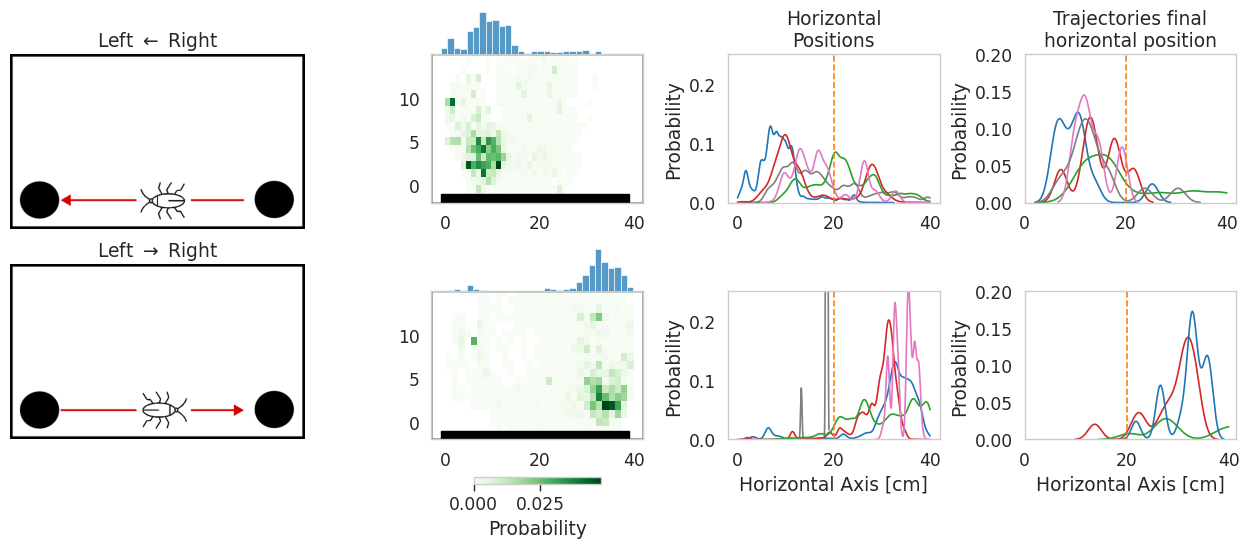

In [8]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def plot_figure4(animal_id=None, single_animal='PV42', excluded_animals=None):
    if animal_id:
        animal_id = [animal_id]
    
    fig = plt.figure(figsize=(16, 5))
    grid = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 5], wspace=0.2)
    
    movement_type = 'low_horizontal'
    cols = 3
    sa = SpatialAnalyzer(animal_ids=animal_id, movement_type=movement_type, start_date='2023-04-18',
                         split_by=['exit_hole'], bodypart='nose', is_use_db=True, excluded_animals=excluded_animals)  # cache_dir=f'{FIGURE_PATH}/cache'
    main_grid = grid[0, 1].subgridspec(2, cols, wspace=0.4, hspace=0.6)
    axes = main_grid.subplots()
    sa.plot_spatial_hist(single_animal, axes=axes[:, 0], is_title=False, animal_colors=COLORS)
    sa.plot_spatial_x_kde(axes=axes[:, 1], animal_colors=COLORS)
    axes[0, 1].set_title('Horizontal\nPositions')
    sa.plot_trajectories(single_animal, axes=axes[:, 2], only_to_screen=True, cbar_indices=[1], is_title=False,
                         animal_colors=COLORS)
    axes[0, 2].set_title('Trajectories final\nhorizontal position')
    for i in [1, 2]:
        axes[1, i].set_xlabel('Horizontal Axis [cm]')
    
    img_axes = grid[0, 0].subgridspec(2, 1).subplots()
    for i, (img_name, img_title) in enumerate([(movement_type, r'Left $\leftarrow$ Right'), 
                                               ('low_horizontal_left_to_right', r'Left $\rightarrow$ Right')]):
        img = cv2.imread(f'{FIGURE_PATH}/assets/{img_name}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_axes[i].imshow(img, aspect='equal') # extent=[0, 10, 0, 10],
        img_axes[i].set_title(img_title)
        img_axes[i].axis('off')
    
    
    # add_ax_letter(img_axes[0], 'A')
    # add_ax_letter(img_axes[1], 'B')
    # k, letters = 0, ['C', 'D', 'E', 'F', 'G', 'H']
    # for j in range(3):
    #     for i in range(2):
    #         add_ax_letter(axes[i, j], letters[k])
    #         k += 1
    
    # fig.suptitle(animal_id[0] if animal_id else 'All Animals')
    # fig.tight_layout()
    fig.savefig(f'{FIGURE_PATH}/figures/figure4.pdf', bbox_inches = 'tight')
    fig.savefig(f'{FIGURE_PATH}/figures/figure4.png', bbox_inches = 'tight')
    plt.show()
    
    
plot_figure4(excluded_animals=['PV85'])

In [63]:
def get_spatial_data():
    with orm.session() as s:
        orm_res = s.query(Trial, Block, Experiment).join(Block, Block.id == Trial.block_id).join(Experiment, Experiment.id == Block.experiment_id).filter(
            Experiment.arena.in_(['reptilearn4']),
            Experiment.animal_id.not_in(BAD_ANIMALS),
            Experiment.animal_id.startswith('PV'),
            Experiment.start_time > '2023-04-18',
            Block.movement_type.in_(['low_horizontal'])
        ).all()
        df_ = []
        for tr, blk, exp in orm_res:
            df_.append({'trial_id': tr.id, 'block_id': blk.id, 'animal_id': exp.animal_id, 'arena_name': exp.arena, 'n_strikes': len(tr.strikes),
                        'time': tr.start_time, 'exit_hole': blk.exit_hole, 'bug_speed': blk.bug_speed, 'duration': tr.duration})
            
    df_ = pd.DataFrame(df_)
    df_.sort_values(by='time')
    return df_

spf = get_spatial_data()
spf.groupby(['animal_id', 'exit_hole']).trial_id.count()

animal_id  exit_hole  
PV163      bottomLeft     100
           bottomRight      5
PV91       bottomLeft     100
           bottomRight    100
PV99       bottomLeft     100
           bottomRight    100
Name: trial_id, dtype: int64

In [57]:
def load_top_pose(spf_):
    res = {}
    with orm.session() as s:
        for animal_id in tqdm(spf_.animal_id.unique()):
            min_date = spf_.query(f'animal_id=="{animal_id}"').time.min()
            max_date = spf_.query(f'animal_id=="{animal_id}"').time.max()
            
            for vid in s.query(Video).filter_by(animal_id=animal_id, cam_name='top').all():
                if vid.predictions and min_date < vid.start_time < max_date:
                    vp = vid.predictions[-1]
                    d = res.setdefault(animal_id, {}) 
                    d[vid.start_time] = pd.read_json(vp.data)
    return res

top_pose = load_top_pose(spf) 

  0%|          | 0/3 [00:00<?, ?it/s]

In [102]:
def circular_hist(ax, x, bins=16, density=True, offset=0, gaps=True):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                     edgecolor='C0', fill=False, linewidth=1)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

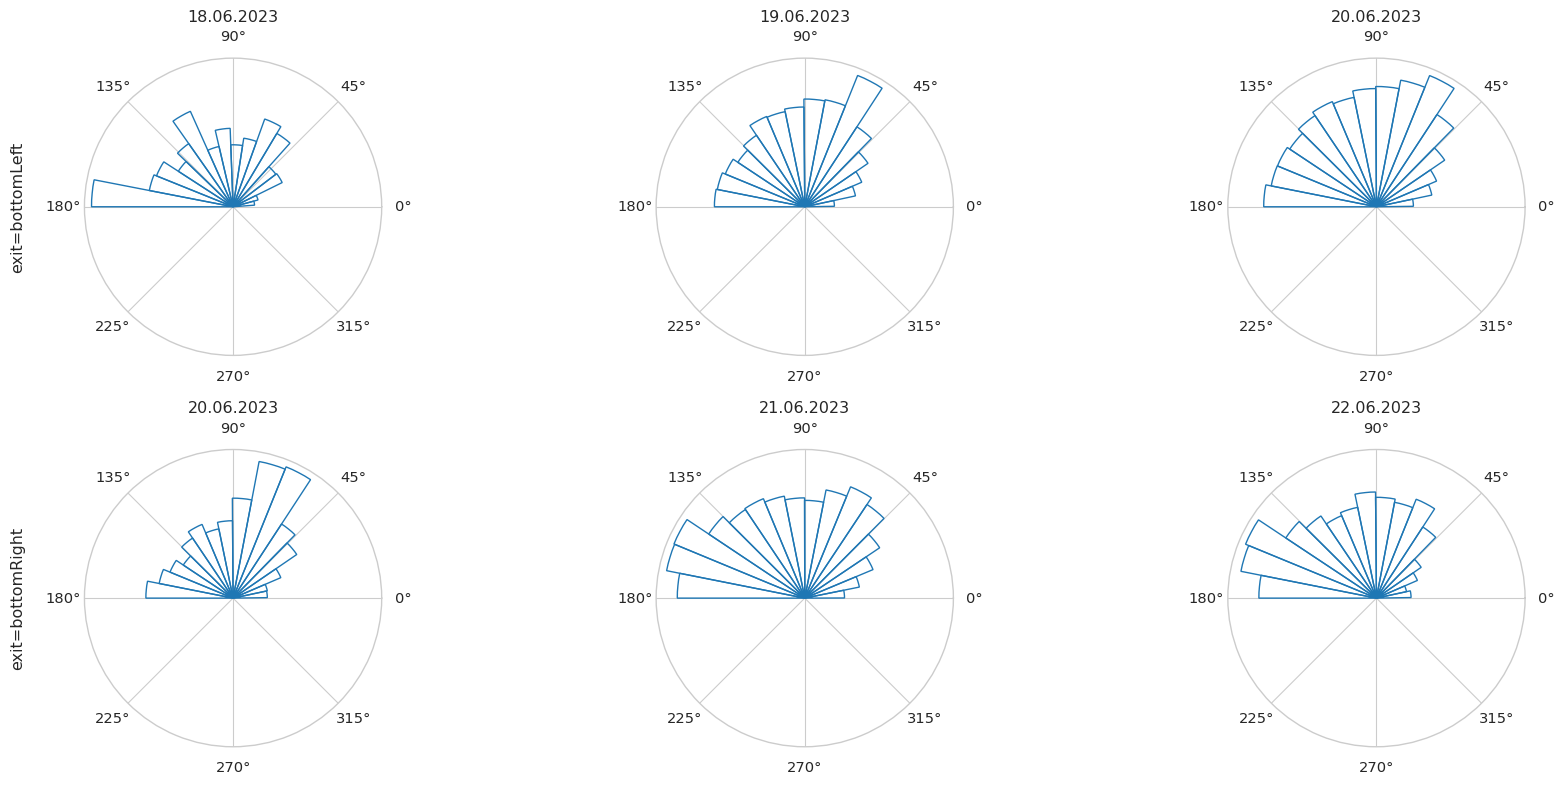

In [115]:
def calc_angle_between_lines(a1, b1, a2, b2):
    return np.arccos((a1*a2 + b1*b2) / (np.sqrt(a1**2 + b1**2) * np.sqrt(a2**2 + b2**2)))

def calc_gaze_deviation_angle(ang, bug_y, bug_x, x, y):
    m_exp = (y - bug_y) / (x - bug_x)
    if ang == np.pi/2:
        x_obs = x
        dev_ang = np.math.degrees(calc_angle_between_lines(1, 0, m_exp, -1))
    else:
        m_obs = np.tan(np.pi-ang)
        n_obs = y - m_obs*x
        x_obs = (bug_y - n_obs)/m_obs
        a = distance.euclidean((bug_x, bug_y), (x, y))
        b = distance.euclidean((x_obs, bug_y), (x, y))
        c = np.abs(x_obs - bug_x)
        dev_ang = np.arccos((a**2 + b**2 - c**2) / (2*a*b))
        if ang > np.pi:
            dev_ang = np.pi - dev_ang
        dev_ang = np.math.degrees(dev_ang)

    sgn = np.sign(x_obs - bug_x) if ang < np.pi else -np.sign(x_obs - bug_x)
    return sgn * dev_ang, x_obs

def plot_mean_low_horizontal_angles():
    fig, axes = plt.subplots(len(top_pose), 1, figsize=(10, 4*len(top_pose)))
    for i, (animal_id, d) in enumerate(top_pose.items()):
        res = []
        for k, pf in sorted(d.items(), key=lambda x: x[0]):
            pf = pf.copy()
            pf["('angle', '')"] = pf["('angle', '')"].map(np.rad2deg)
            a = pf["('angle', '')"].values
            a = savgol_filter(a, 51, 0)
            a = a[a<=180]
            if not len(a):
                continue
            res.append({'time': k, 'mean_angle': np.nanmean(a)})
            
        res = pd.DataFrame(res)
        axes[i].scatter(res.time, res.mean_angle)
        for side in ['bottomRight', 'bottomLeft']:
            spf_ = spf.query(f'animal_id=="{animal_id}" and exit_hole=="{side}"')
            if spf_.empty:
                continue
            t = spf_.time.min()
            axes[i].axvline(t, color='k', linestyle='--')
            axes[i].text(t, 180, side)
        axes[i].axhline(90, color='r')
        axes[i].set_ylim([0, 180])
        axes[i].set_title(animal_id)
        # axes[i].set_xticks(rotation=45)
    fig.tight_layout()

def plot_polar_hist_low_horizontal_angles(animal_id):
    res = {}
    for side in ['bottomLeft', 'bottomRight']:
        spf_ = spf.query(f'animal_id=="{animal_id}" and exit_hole=="{side}"')
        if spf_.empty:
            continue
        res[side] = {}
        t_start, t_stop = spf_.time.min(), spf_.time.max()
        for k, pf in sorted(top_pose[animal_id].items(), key=lambda x: x[0]):
            if k < t_start or k > t_stop:
                continue
            day = k.strftime('%d.%m.%Y')
            pf = pf.copy()
            # pf["('angle', '')"] = pf["('angle', '')"].map(np.rad2deg)
            a = pf["('angle', '')"].values
            a = savgol_filter(a, 51, 0)
            a = a[a<=np.pi]
            if not len(a):
                continue
            res[side].setdefault(day, []).extend(a.tolist())
    
    cols = max([len(res[side]) for side in res])
    fig, axes = plt.subplots(len(res), cols, figsize=(18, 4*len(res)), subplot_kw=dict(projection='polar'))
    for i, (side, d) in enumerate(res.items()):
        for j, (day, a) in enumerate(sorted(d.items(), key=lambda x: x[0])):
            circular_hist(axes[i, j], np.array(a))
            axes[i, j].set_title(day)
            if j == 0:
                axes[i, j].set_ylabel(f'exit={side}')
                axes[i, j].yaxis.set_label_coords(-0.2, 0.5)
    fig.tight_layout()
            
    
plot_polar_hist_low_horizontal_angles('PV91')

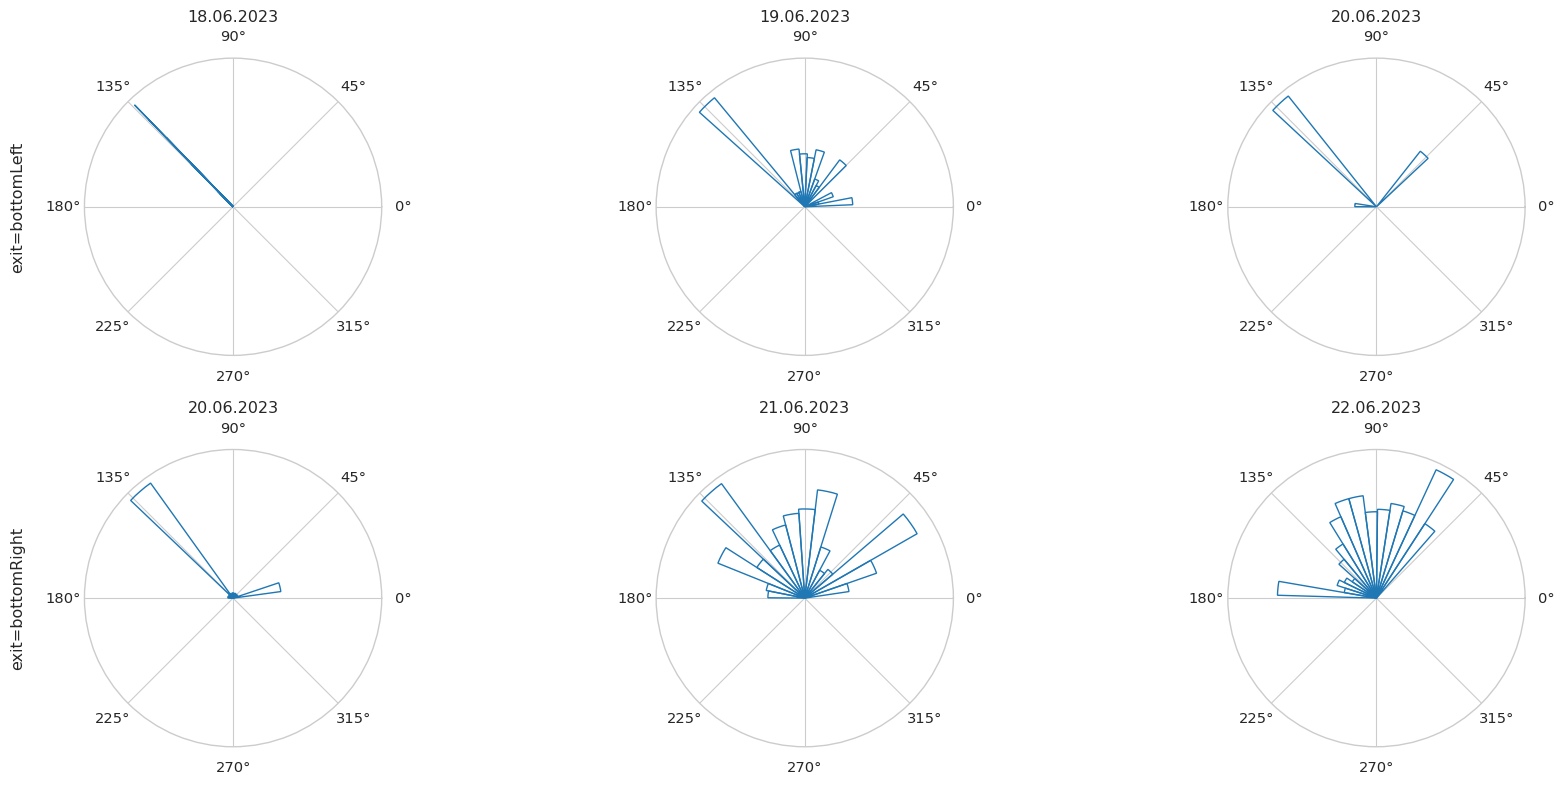

In [124]:
def get_pose_df(blk):
    dlc = DLCArenaPose('front', orm=orm)
    pose_df = []
    for vid in blk.videos:
        try:
            pdf_ = dlc.load(video_db_id=vid.id)
            pose_df.append(pdf_)
        except Exception:
            pass
    if not pose_df:
        return
    pose_df = pd.concat(pose_df)
    pose_df.columns = ['_'.join(c) if c[1] else c[0] for c in pose_df.columns]
    return pose_df
    
def get_low_horizontal_angles_block_start(animal_id):
    res = {}
    with orm.session() as s:
        for side in ['bottomLeft', 'bottomRight']:
            block_ids = spf.query(f'animal_id=="{animal_id}" and exit_hole=="{side}"').sort_values(by=['time']).block_id.values.tolist()
            if len(block_ids) == 0:
                continue
            res[side] = {}
            for block_id in block_ids:
                blk = s.query(Block).filter_by(id=block_id).first()
                pose_df = get_pose_df(blk)
                if pose_df is not None:
                    day = blk.start_time.strftime('%d.%m.%Y')
                    a = savgol_filter(pose_df.angle.values, 51, 0)
                    a = a[:(5*60)]  # only the first 29 seconds, when bugs still not on screen
                    a = a[a<=np.pi]
                    if not len(a):
                        continue
                    res[side].setdefault(day, []).extend(a.tolist())
    return res


def plot_block_start_low_horizontal(res):
    cols = max([len(res[side]) for side in res])
    fig, axes = plt.subplots(len(res), cols, figsize=(18, 4*len(res)), subplot_kw=dict(projection='polar'))
    for i, (side, d) in enumerate(res.items()):
        for j, (day, a) in enumerate(sorted(d.items(), key=lambda x: x[0])):
            circular_hist(axes[i, j], np.array(a))
            axes[i, j].set_title(day)
            if j == 0:
                axes[i, j].set_ylabel(f'exit={side}')
                axes[i, j].yaxis.set_label_coords(-0.2, 0.5)
    fig.tight_layout()
    

bs = get_low_horizontal_angles_block_start(animal_id)
plot_block_start_low_horizontal(bs)

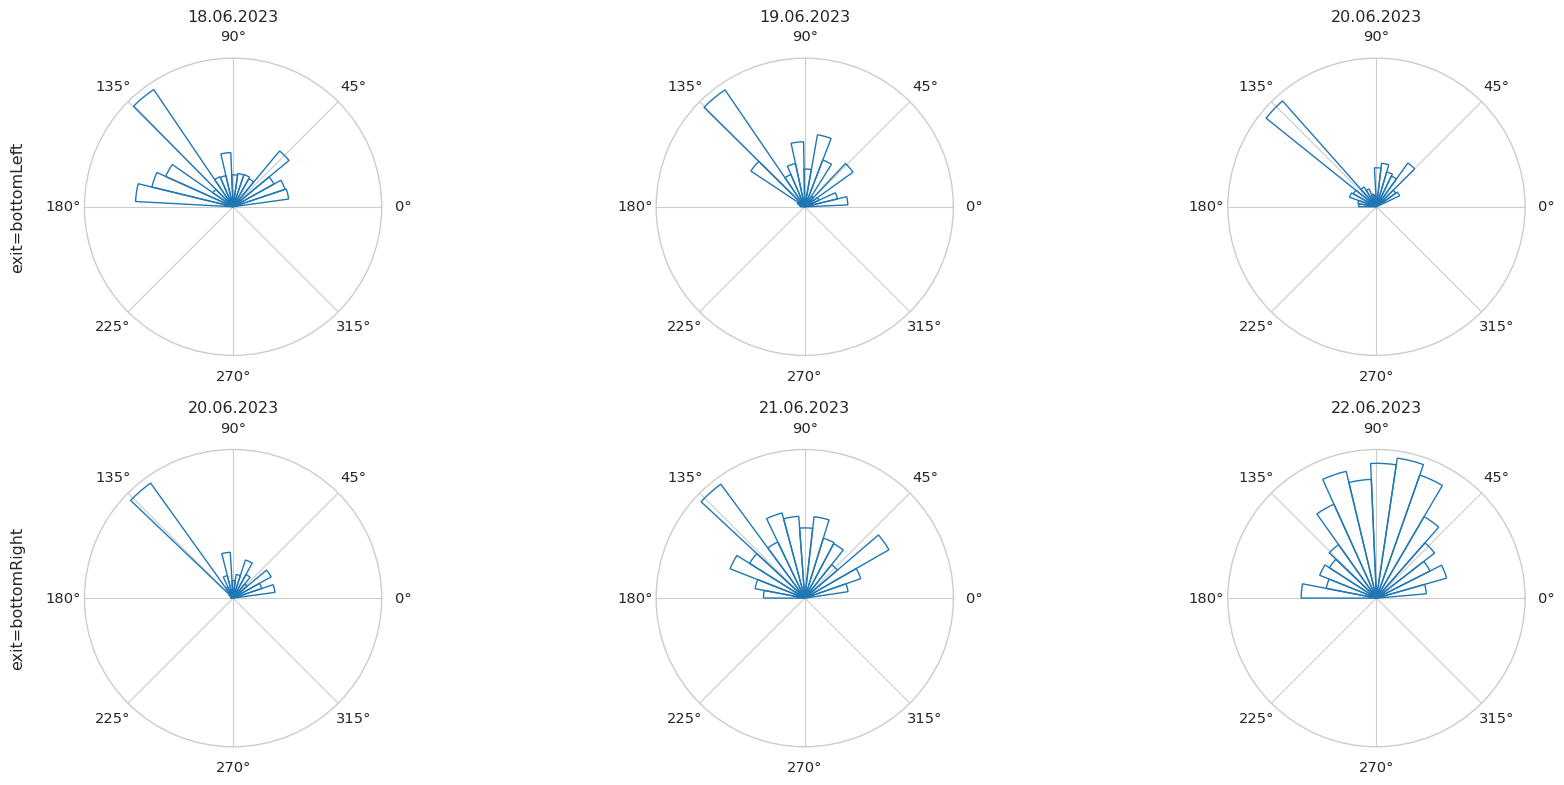

In [107]:
dt = list(top_pose['PV91'].keys())[0]
top_pose['PV91'][dt]

,"('left_ear', 'cam_x')","('left_ear', 'cam_y')","('left_ear', 'prob')","('mid_ears', 'cam_x')","('mid_ears', 'cam_y')","('mid_ears', 'prob')","('nose', 'cam_x')","('nose', 'cam_y')","('nose', 'prob')","('right_ear', 'cam_x')",...,"('left_ear', 'x')","('left_ear', 'y')","('mid_ears', 'x')","('mid_ears', 'y')","('angle', '')","('bug_x_cm', '')","('bug_x', '')","('bug_y', '')","('trial_id', '')","('dev_angle', '')"
0,2.040484,-0.742525,0.000023,1.104470,0.848662,0.000021,5.189479,6.001561,0.000023,0.168456,...,75.129755,-9.060907,75.011257,-9.139971,3.748701,NaN,NaN,NaN,NaN,NaN
1,2.040484,-0.742525,0.000023,1.104470,0.848662,0.000021,5.189479,6.001561,0.000023,0.168456,...,75.129755,-9.060907,75.011257,-9.139971,3.748701,NaN,NaN,NaN,NaN,NaN
2,2.040484,-0.742525,0.000023,1.104470,0.848662,0.000021,5.189479,6.001561,0.000023,0.168456,...,75.129755,-9.060907,75.011257,-9.139971,3.748701,NaN,NaN,NaN,NaN,NaN
3,2.040484,-0.742525,0.000023,1.104470,0.848662,0.000021,5.189479,6.001561,0.000023,0.168456,...,75.129755,-9.060907,75.011257,-9.139971,3.748701,NaN,NaN,NaN,NaN,NaN
4,2.040484,-0.742525,0.000023,1.104470,0.848662,0.000021,5.189479,6.001561,0.000023,0.168456,...,75.129755,-9.060907,75.011257,-9.139971,3.748701,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17997,69.448547,978.354736,0.908264,108.658653,971.116211,0.558802,97.620674,1034.485840,0.999154,147.868759,...,-3.966290,-5.785396,-3.053780,-2.071867,2.878540,NaN,NaN,NaN,NaN,NaN
17998,69.376991,978.297607,0.896184,108.669235,971.085205,0.543192,97.648239,1034.473022,0.999132,147.961487,...,-3.961551,-5.791539,-3.050887,-2.070573,2.878812,NaN,NaN,NaN,NaN,NaN
17999,69.467407,978.267029,0.903849,108.677650,971.072510,0.554277,97.641357,1034.512207,0.999155,147.887894,...,-3.958348,-5.783013,-3.049665,-2.069660,2.878747,NaN,NaN,NaN,NaN,NaN
18000,69.405067,978.250854,0.895852,108.679199,971.058960,0.543322,97.646339,1034.467407,0.999130,147.953323,...,-3.957221,-5.788614,-3.048428,-2.069384,2.878696,NaN,NaN,NaN,NaN,NaN


In [40]:
spf.query('animal_id=="PV91" and exit_hole=="bottomRight"').time.min()

Timestamp('2023-06-20 14:30:46.805000')

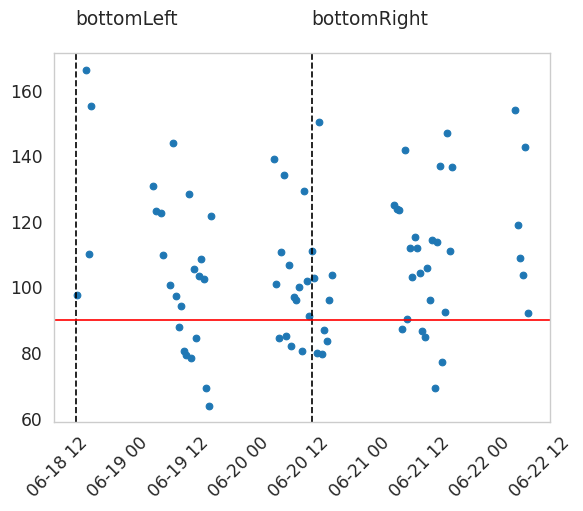

In [53]:

# cols = 5
# rows = int(np.ceil(len(top_pose) / cols))
# fig, axes = plt.subplots(rows, cols, figsize=(25, 4*rows))
# axes = axes.flatten()

res = []
for i, (k, pf) in enumerate(sorted(top_pose.items(), key=lambda x: x[0])):
    pf = pf.copy()
    pf["('angle', '')"] = pf["('angle', '')"].map(np.rad2deg)
    a = pf["('angle', '')"].values
    a = savgol_filter(a, 51, 0)
    a = a[a<=180]
    if not len(a):
        continue
    res.append({'time': k, 'mean_angle': np.nanmean(a)})
    # axes[i].set_ylim([0, 360])
    # axes[i].axhline(180, color='r')
    # axes[i].axhline(90, color='k', linestyle='--')
    # axes[i].axvline(90, color='r')
    # axes[i].hist(a, bins=np.arange(0, 180, 5))
    # axes[i].set_title(k)
    
res = pd.DataFrame(res)
plt.scatter(res.time, res.mean_angle)
for side in ['bottomRight', 'bottomLeft']:
    t = spf.query(f'animal_id=="{animal_id}" and exit_hole=="{side}"').time.min()
    plt.axvline(t, color='k', linestyle='--')
    plt.text(t, 180, side)
plt.axhline(90, color='r')
plt.xticks(rotation=45)
plt.show()

# fig.tight_layout()

In [109]:
Loader(15224, 'top', is_trial=True, orm=orm)

MissingStrikeData: frames_df is empty after loading

In [106]:
spf.query('animal_id=="PV91"')

,trial_id,block_id,animal_id,arena_name,n_strikes,time,exit_hole,bug_speed,duration
170,15224,1986,PV91,reptilearn4,0,2023-06-18 15:31:29.967,bottomLeft,6,3.905
171,15225,1986,PV91,reptilearn4,3,2023-06-18 15:31:55.242,bottomLeft,6,5.694
172,15236,1986,PV91,reptilearn4,0,2023-06-18 15:32:22.513,bottomLeft,6,3.923
173,15237,1986,PV91,reptilearn4,0,2023-06-18 15:32:47.813,bottomLeft,6,3.923
174,15238,1986,PV91,reptilearn4,0,2023-06-18 15:33:13.116,bottomLeft,6,3.919
...,...,...,...,...,...,...,...,...,...
478,15635,2054,PV91,reptilearn4,1,2023-06-22 09:31:55.070,bottomRight,6,3.924
479,15636,2054,PV91,reptilearn4,3,2023-06-22 09:32:20.391,bottomRight,6,3.919
480,15637,2054,PV91,reptilearn4,1,2023-06-22 09:32:45.579,bottomRight,6,3.929
481,15638,2054,PV91,reptilearn4,5,2023-06-22 09:31:05.049,bottomRight,6,3.913


# Supplementary

## Trajectory Models

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

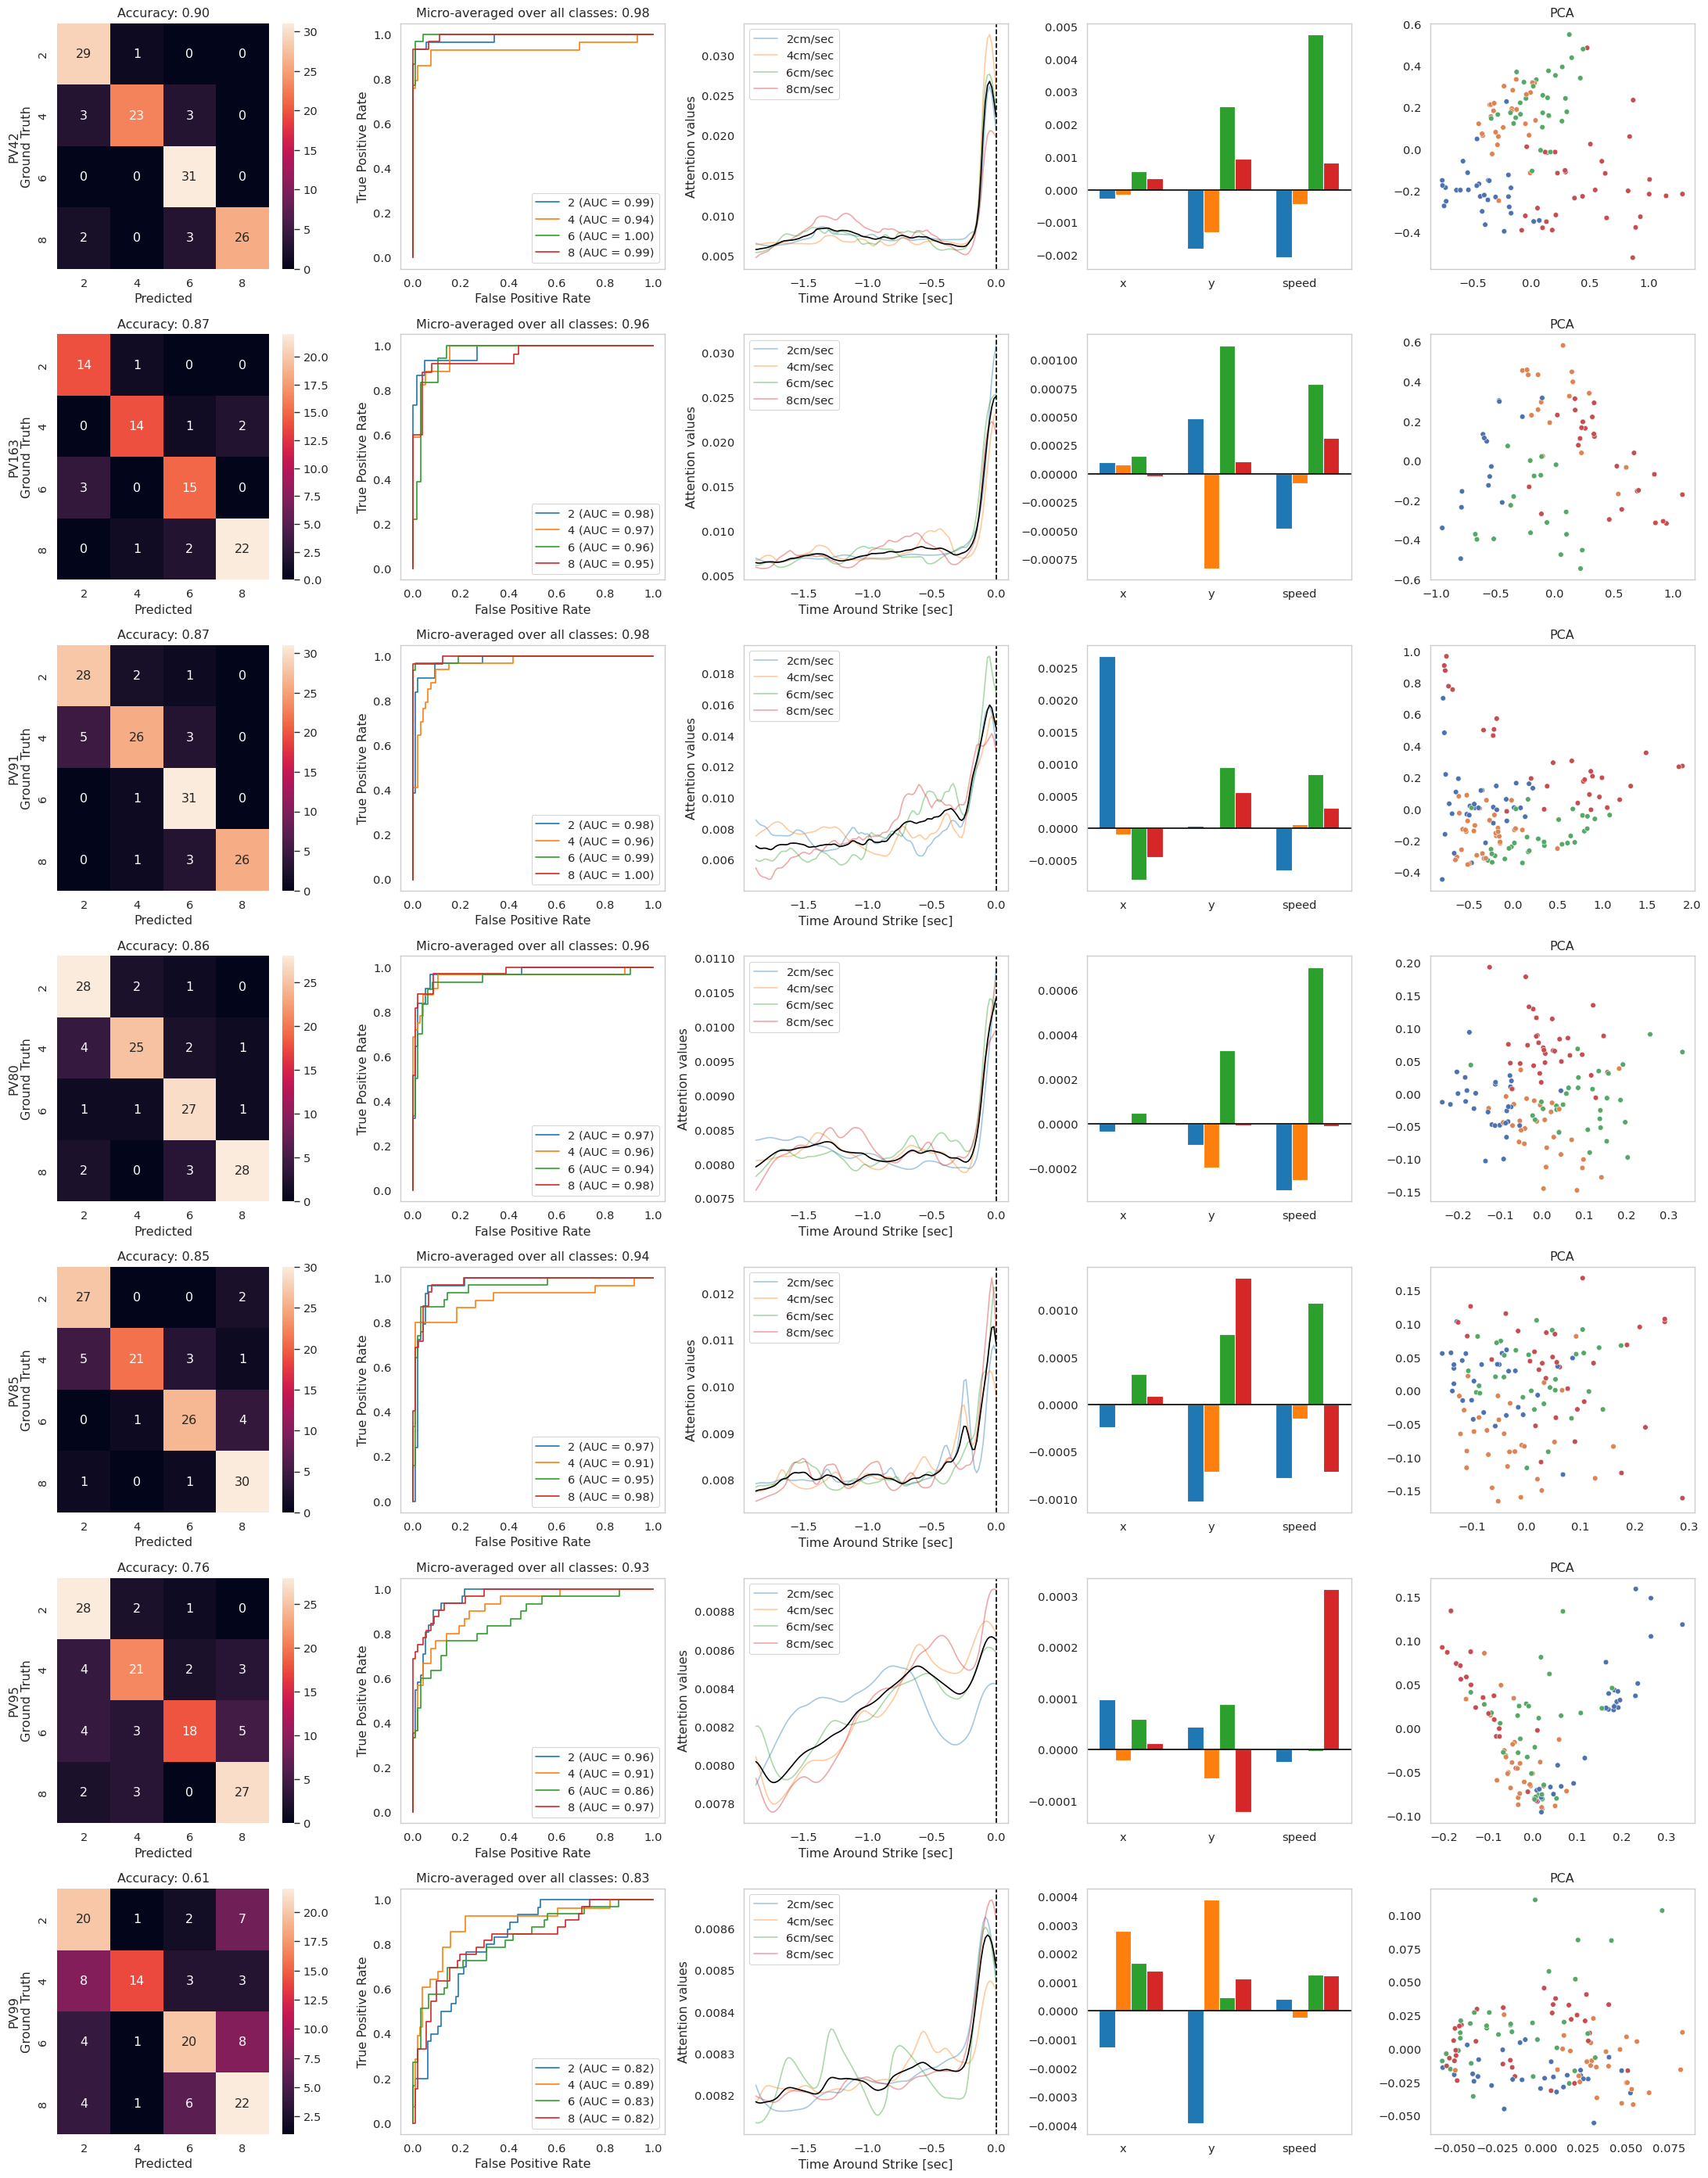

In [28]:
def plot_supp_traj_models():
    sns.set_context('paper', font_scale=1.2)
    fig, axes = plt.subplots(len(traj_model_paths), 5, figsize=(22, 4*len(traj_model_paths)))
    for i, (animal_id, (model_path, _)) in enumerate(traj_model_paths.items()):
        model_path = f'{TRAJ_DIR}/{model_path}'
        tj = TrajClassifier(model_path=model_path, is_debug=False)
        tj.all_data_evaluation(axes=axes[i, :3])
        tj.check_hidden_states(axes=axes[i, 3:], is_legend=False)
        axes[i, 0].set_ylabel(f'{animal_id}\nGround Truth')
    fig.tight_layout()
    fig.savefig(f'{FIGURE_PATH}/figures/figure_S1.pdf')
    fig.savefig(f'{FIGURE_PATH}/figures/figure_S1.png')

plot_supp_traj_models()

## Balistic Movement

In [79]:
sdf = calc_strikes_dynamics(is_cache=True, movement_type='random_low_horizontal', sec_after=0)

In [80]:
def calc_exit_hole(xf):
    res = {}
    for bug_speed, d in xf.items():
        for sid, _ in d.items():
            trial_id = int(df.loc[df.strike_id==sid].trial_id.iloc[0])
            with orm.session() as s:
                tr = s.query(Trial).filter_by(id=trial_id).first()
                bug_trajs = pd.DataFrame(tr.bug_trajectory)
                bug_trajs = bug_trajs.rename(columns={'x': 'bug_x', 'y': 'bug_y'})
                first_x_id = bug_trajs.bug_x.dropna().index[0]
                exit_hole = 'right' if bug_trajs.bug_x.loc[first_x_id] < 300 else 'left'
                res[sid] = exit_hole
    
    return res

exits_holes = calc_exit_hole(sdf)

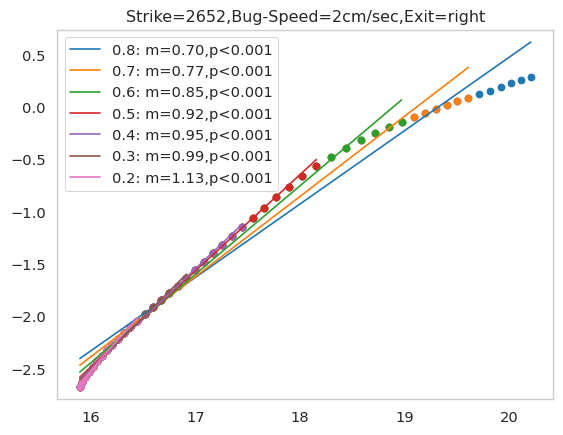

In [81]:
def plot_ballistic_example(strike_id, speed, xf):
    dT = np.arange(0.8, 0.1, -0.1)
    exit_hole = exits_holes[strike_id]
    t, y, _, x = xf[speed][strike_id]

    t_ = (t - t.iloc[-1]).reset_index(drop=True)
    colors = list(TABLEAU_COLORS.values())
    plt.figure()
    for i, dt in enumerate(dT):
        idx = t_[t_>-dt].index
        slope, intercept, r_value, p_value, std_err = linregress(x[idx], y[idx])
        y_pred = intercept + slope*x[idx]

        plt.scatter(x[idx], y[idx], color=colors[i])
        p_val_text = 'p<0.001' if p_value <= 0.001 else f'p={p_value:.3f}'
        plt.plot(x[idx], y_pred, color=colors[i], label=f'{dt:.1f}: m={slope:.2f},{p_val_text}')
    
    plt.legend()
    plt.axis('equal')
    plt.title(f'Strike={strike_id},Bug-Speed={speed:.0f}cm/sec,Exit={exit_hole}')


# plot_ballistic_example(2572, 6, sdf)
plot_ballistic_example(2652, 2, sdf)

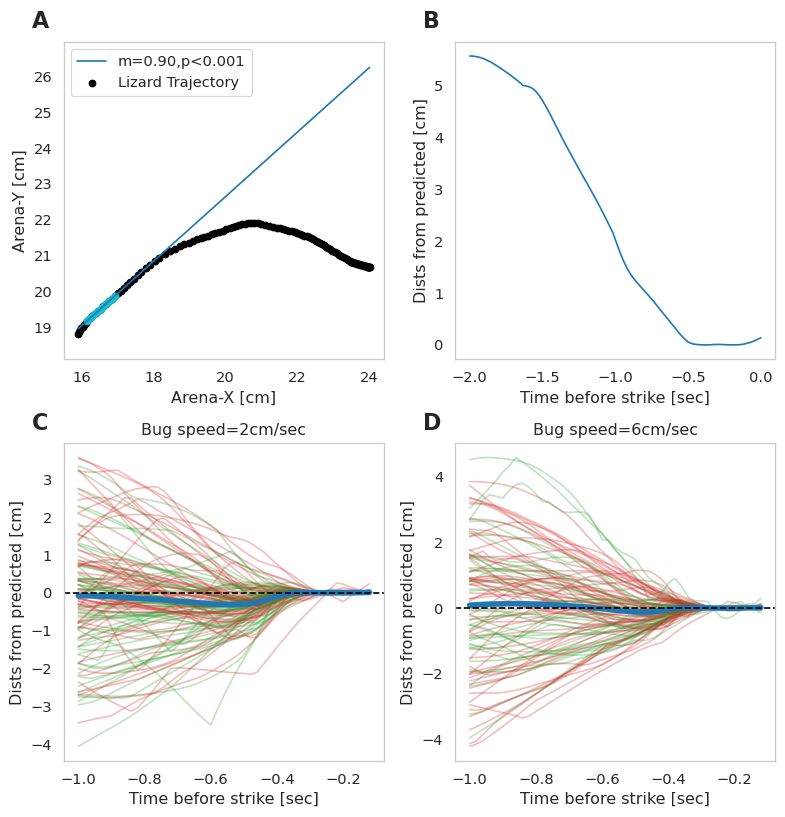

In [92]:
def get_dist_from_predicted(t, x, y, reg_len=0.2):
    t_ = (t - t.iloc[-1]).reset_index(drop=True)
    idx = t_[(t_<=-0.1)&(t_>=(-0.1-reg_len))].index
    slope, intercept, r_value, p_value, std_err = linregress(x[idx], y[idx])
    y_pred = intercept + slope*x
    dists = y_pred - y
    return t_, dists, y_pred, idx, slope, p_value

def ballistic_analysis(ax, xf, speed=None, title=None):
    global_t = np.arange(-1, -0.1, 0.02)
    res = []
    for bug_speed, d in xf.items():
        if speed and bug_speed != speed:
            continue
        for sid, (t, y, _, x) in d.items():
            exit_hole = exits_holes[sid]
            t_, dists, y_pred, idx, slope, p_value = get_dist_from_predicted(t, x, y)
            if p_value > 0.05 or any(np.abs(dists) > 5):
                continue
            d_ = np.interp(global_t, t_, dists, left=np.nan, right=np.nan)
            ax.plot(global_t, d_, color='tab:red' if exit_hole == 'left' else 'tab:green', alpha=0.3)
            res.append(d_)
    
    avg_dist = np.nanmean(np.vstack(res), axis=0)
    ax.plot(global_t, avg_dist, linewidth=4)
    ax.axhline(0, linestyle='--', color='k')
    ax.set_xlabel('Time before strike [sec]')
    ax.set_ylabel('Dists from predicted [cm]')
    if title:
        ax.set_title(title)


def plot_ballistic_example(strike_id, speed, xf, axes=None):
    exit_hole = exits_holes[strike_id]
    t, y, _, x = xf[speed][strike_id]
    y -= SCREEN_Y_POS['reptilearn4']
    t_, dists, y_pred, idx, slope, p_value = get_dist_from_predicted(t, x, y)

    if axes is None:
        fig, axes = plt.subplots(1,2,figsize=(8, 4))
    axes[0].scatter(x, y, color='k', label='Lizard Trajectory')
    axes[0].scatter(x[idx], y[idx], color='tab:cyan')
    p_val_text = 'p<0.001' if p_value <= 0.001 else f'p={p_value:.3f}'
    axes[0].plot(x, y_pred, color='tab:blue', label=f'm={slope:.2f},{p_val_text}')
    axes[0].legend()
    axes[0].axis('equal')
    axes[0].set_xlabel('Arena-X [cm]')
    axes[0].set_ylabel('Arena-Y [cm]')
    # axes[0].set_title(f'Strike={strike_id},Bug-Speed={speed:.0f}cm/sec,Exit={exit_hole}')

    axes[1].plot(t_, dists)
    axes[1].set_xlabel('Time before strike [sec]')
    axes[1].set_ylabel('Dists from predicted [cm]')
    if axes is None:
        fig.tight_layout()


# plot_ballistic_example(2572, 6, sdf)
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
plot_ballistic_example(2652, 2, sdf, axes=axes[0,:])
ballistic_analysis(axes[1,0], sdf, speed=2, title='Bug speed=2cm/sec')
ballistic_analysis(axes[1,1], sdf, speed=6, title='Bug speed=6cm/sec')
fig.tight_layout()
for letter, ax in zip('ABCD', [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]):
    add_ax_letter(ax, letter, x=-0.1, y=1.1)
fig.savefig(f'{FIGURE_PATH}/figures/ballistic.pdf', bbox_inches='tight')

In [ ]:
import warnings

def get_balistic_angle(a1, b1, a2, b2):
    return np.arccos((a1*a2 + b1*b2) / (np.sqrt(a1**2 + b1**2) * np.sqrt(a2**2 + b2**2)))


def ballistic_analysis(xf, strike_id=None, speed=None, n_dots_after=25, cols=4):
    dT = np.arange(0.2, 0.9, 0.1)
    rows = int(np.ceil(len(dT)/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(25, 4*rows))
    axes = axes.flatten()
    for bug_speed, d in xf.items():
        if speed and bug_speed != speed:
            continue
        for sid, (t, y, _, x) in d.items():
            if strike_id and sid != strike_id:
                continue
            # t, y, _, x = xf[speed][sid]
            t_ = (t - t.iloc[-1]).reset_index(drop=True)
            exit_hole = exits_holes[sid]
            color = 'tab:blue' if exit_hole == 'right' else 'tab:orange'
            # axes[0].scatter(x, y, color='k')
            
            for i, dt in enumerate(dT):
                t_ = (t - t.iloc[-1]).reset_index(drop=True)
                idx = sorted(t_[(t_>-dt) & (t_ < -0.1)].index)
                a1, c1, r_value, p_value, std_err = linregress(x[idx], y[idx])
                # original_angle = np.arctan(slope)
                z = []
                for k in range(n_dots_after):
                    dot_id = idx[0] - (k + 1)
                    a2 = (y[idx[0]]-y[dot_id]) / (x[idx[0]]-x[dot_id])
                    sgn = np.sign((a1*x[dot_id] + c1) - y[dot_id])
                    ang = sgn * get_balistic_angle(a1, -1, a2, -1)
                    z.append(np.math.degrees(ang))
                axes[i].scatter(np.arange(n_dots_after).astype(int), z, color=color, alpha=0.5)
                axes[i].set_title(f'dt=-{dt:.1f},slope={a1:.2f},p={p_value:.3f}')
                axes[i].set_ylim([-2, 45])

    fig.tight_layout()


# ballistic_analysis(sdf, strike_id=2572)
ballistic_analysis(sdf, strike_id=2652)

In [ ]:
def ballistic_avg_analysis(xf, strike_id=None, speed=None, n_dots_after=25, cols=4):
    dT = np.arange(0.2, 1.1, 0.1)
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    all_res = {'right': [], 'left': []}
    for bug_speed, d in xf.items():
        if speed and bug_speed != speed:
            continue
        for sid, (t, y, _, x) in d.items():
            if strike_id and sid != strike_id:
                continue
            # t, y, _, x = xf[speed][sid]
            t_ = (t - t.iloc[-1]).reset_index(drop=True)
            exit_hole = exits_holes[sid]
            color = 'tab:blue' if exit_hole == 'right' else 'tab:orange'
            # axes[0].scatter(x, y, color='k')
            
            r = []
            for i, dt in enumerate(dT):
                t_ = (t - t.iloc[-1]).reset_index(drop=True)
                idx = sorted(t_[(t_>-dt) & (t_ < -0.1)].index)
                a1, c1, r_value, p_value, std_err = linregress(x[idx], y[idx])
                # original_angle = np.arctan(slope)
                z = []
                for k in range(n_dots_after):
                    dot_id = idx[0] - (k + 1)
                    a2 = (y[idx[0]]-y[dot_id]) / (x[idx[0]]-x[dot_id])
                    sgn = np.sign((a1*x[dot_id] + c1) - y[dot_id])
                    ang = sgn * get_balistic_angle(a1, -1, a2, -1)
                    z.append(np.math.degrees(ang))
                r.append(np.mean(z))
            all_res[exit_hole].append(r)
            ax.scatter(dT, r, color=color, alpha=0.4)
            # ax.set_title(f'dt=-{dt:.1f},slope={a1:.2f},p={p_value:.3f}')
            # ax.set_ylim(0, 50)
    if strike_id is None:
        ax.plot(dT, np.mean(all_res['right'], axis=0), 'o-', color='tab:blue')
        ax.plot(dT, np.mean(all_res['left'], axis=0), 'o-', color='tab:orange')


ballistic_avg_analysis(sdf, speed=6)

In [ ]:
r = sdf[2][0]
fig, ax = plt.subplots()
lc = colorline(ax, r[3], r[1], r[0])
cbar = fig.colorbar(lc, ax=ax)

In [ ]:
cols = 6
for bug_speed in [2, 6]:
    rows = int(np.ceil(len(sdf[bug_speed])/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(25, 4*rows))
    axes = axes.flatten()
    i = 0
    for sid, l in sdf[bug_speed].items():
        colorline(axes[i], l[3], l[1], l[0])
        axes[i].set_xlim([0, 60])
        axes[i].set_title(f'{sid}')
        i += 1
    fig.tight_layout()

### Head-Bug Correlation

In [6]:
def calc_head_bug_correlation(af, th=0.8, is_plot=False):
    af = af.copy()
    af.columns = ['_'.join(c) if c[1] else c[0] for c in af.columns]
    af = af.query(f'nose_prob>{th} and right_ear_prob>{th} and left_ear_prob>{th} and bug_x_cm==bug_x_cm').copy()
    af['angle'] = af.angle.map(np.rad2deg)
    corr = np.corrcoef(af.angle, -af.bug_x_cm)[0, 1]
    if is_plot:
        af['total_sec'] = (af.time - af.time.iloc[0]).dt.total_seconds()
        ax = plt.subplot()
        ax.set_title(f'Correlation={corr:.2f}')
        ax.plot(af.total_sec, af.angle, color='tab:blue')
        ax.tick_params(axis='y', labelcolor='tab:blue')
        ax2 = ax.twinx()
        ax2.plot(af.total_sec, af.bug_x_cm, color='tab:orange', zorder=-1)
        ax2.invert_yaxis()
        ax2.set_ylabel('Bug_x [cm]', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')
    return corr

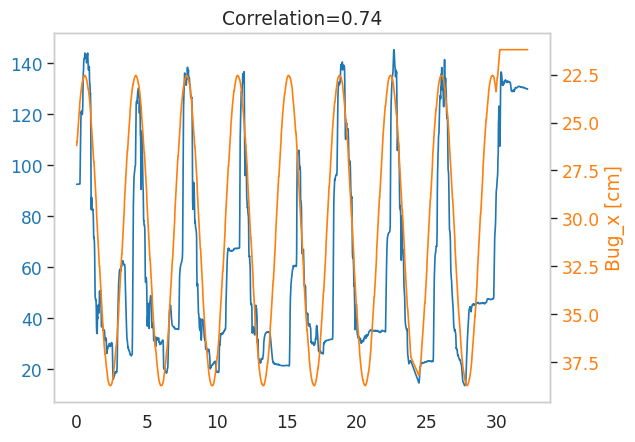

In [59]:
ld = Loader(11136, 'front', is_trial=True, is_load_pose=True, is_dwh=True)
corr = calc_head_bug_correlation(ld.frames_df)

In [17]:
df

,strike_id,time,animal_id,miss_distance,pred_distance,movement_type,calc_speed,bug_size,proj_bug_x,is_hit,trial_id,block_id,arena_name,day,proj_strike_x,proj_strike_y,day_num
0,3093,2023-05-24 10:00:54.573,PV42,45.607017,0.779532,jump_up,4.140111,163,-68.0,True,11947,1572,msi-regev,2023-05-24,-36.0,-28.0,26.0
1,3094,2023-05-24 10:04:03.744,PV42,77.103826,0.320173,jump_up,4.046848,143,-60.0,True,11954,1572,msi-regev,2023-05-24,-77.0,-4.0,26.0
2,107,2023-04-22 10:01:32.224,PV85,33.955854,0.249356,random_low_horizontal,2.100104,165,-22.0,True,6414,1031,msi-regev,2023-04-22,-33.0,-8.0,4.0
3,108,2023-04-22 10:04:15.172,PV85,19.235384,0.173923,random_low_horizontal,2.085246,163,-28.0,True,6420,1031,msi-regev,2023-04-22,-19.0,-3.0,4.0
4,110,2023-04-22 10:05:10.516,PV85,43.416587,0.443417,random_low_horizontal,2.066818,146,-26.0,True,6349,1031,msi-regev,2023-04-22,-38.0,-21.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6063,8859,2024-02-24 09:31:23.856,PV91,63.007936,NaN,accelerate,NaN,100,NaN,True,31868,4007,reptilearn4,2024-02-24,NaN,NaN,287.0
6064,8860,2024-02-24 11:33:43.307,PV91,143.000000,NaN,jump_up,NaN,100,NaN,False,31892,4009,reptilearn4,2024-02-24,NaN,NaN,287.0
6065,8861,2024-02-24 13:33:13.278,PV91,147.085009,NaN,jump_up,NaN,100,NaN,False,31911,4004,reptilearn4,2024-02-24,NaN,NaN,287.0
6066,8862,2024-02-24 13:33:14.861,PV91,141.173652,NaN,jump_up,NaN,100,NaN,False,31911,4004,reptilearn4,2024-02-24,NaN,NaN,287.0


(-0.019724175052817875, 0.869375328565729)

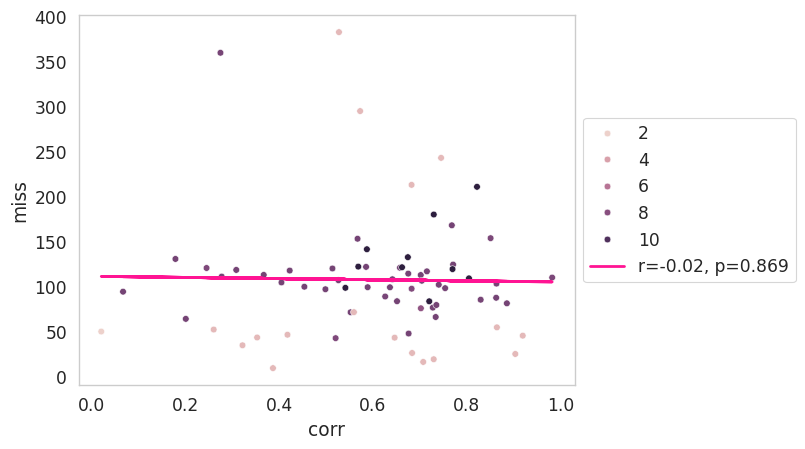

In [43]:
rf = []
for trial_id in df.query('movement_type=="circle" and animal_id=="PV91"').trial_id.unique():
    try:
        ld = Loader(int(trial_id), 'front', is_trial=True, is_load_pose=True, is_dwh=True, orm=orm)
        corr = calc_head_bug_correlation(ld.frames_df)
        miss = df[df.trial_id==trial_id].miss_distance.dropna().mean()
        bug_speed = df[df.trial_id==trial_id].calc_speed.dropna().mean()
        if corr > 0:
            rf.append({'trial_id': trial_id, 'corr': corr,'miss': miss, 'bug_speed': bug_speed})
    except Exception as e:
        continue
        # print(f'Trial {trial_id} failed: {e}')
rf = pd.DataFrame(rf)
sns.scatterplot(data=rf, x='corr', y='miss', hue='bug_speed')
plot_regression(plt.gca(), rf['corr'].values, rf.miss.values)

Text(0, 0.5, 'Prediction Distance [cm]')

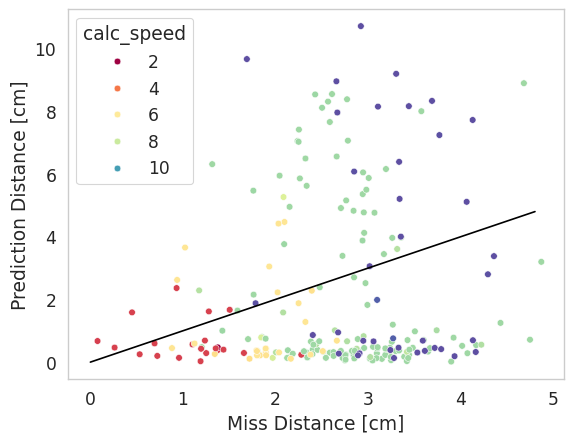

In [46]:
xf = df.query('movement_type=="circle" and animal_id=="PV91" and miss_distance<180').copy()
xf['miss_distance'] = xf.miss_distance.map(lambda x: x * SCREEN_PIX_CM['reptilearn4'])
sns.scatterplot(data=xf, x='miss_distance', y='pred_distance', hue='calc_speed', palette='Spectral')
k = min([xf.miss_distance.max(), xf.pred_distance.max()])
plt.plot(np.arange(0, k, 0.1), np.arange(0, k, 0.1), color='k')
plt.xlabel('Miss Distance [cm]')
plt.ylabel('Prediction Distance [cm]')

### Miss Distance

In [ ]:
def plot_learning_curve(ax, movement_type, labels_fontsize=None, min_strikes=120, animals2drop=None):
    lines_plots = []
    x = []
    for animal_id in df.animal_id.unique():
        if animals2drop and animal_id in animals2drop:
            continue
        af_ = df.query(f'animal_id=="{animal_id}" and movement_type=="{movement_type}"').sort_values(
            by='strike_id').reset_index().copy()
        if af_.empty or (min_strikes and len(af_) < min_strikes):
            continue
        af_ = af_.iloc[:min_strikes]
        miss_distance = savgol_filter(af_.miss_distance, window_length=51, polyorder=0, mode='nearest')
        l = ax.plot(af_.index.tolist(), miss_distance, color=COLORS[animal_id], label=animal_id, alpha=0.4)
        x.append(miss_distance.reshape(1, -1))
        lines_plots.append(l[0])
        # if af_.day_num.min() > 0:
        #     af_['day_num'] = af_.day_num - af_.day_num.min() 
        # g_ = af_.groupby('strike_num').miss_distance.agg(['mean', 'sem'])
        # g_['sem'].fillna(0, inplace=True)
        # ax.errorbar(g_.index, g_['mean'], yerr=g_['sem'], color=COLORS[animal_id], label=animal_id, fmt='-o')
        # plot_regression(ax, af_.round_speed.values, af_.pred_distance.values)

    ax.plot(np.arange(min_strikes), np.vstack(x).mean(axis=0), color='k', linewidth=3)
    ax.set_xlabel('Accumulated Strikes', fontsize=labels_fontsize)
    ax.set_ylabel('Miss Distance [pixels]', fontsize=labels_fontsize)
    return lines_plots


### Time-to-Feeder

In [ ]:
def interpolate_y(pose_df, kind='quadratic'):
    nan_idx = pose_df.index[pose_df.y.isna()].tolist()
    no_nan_idx = pose_df.index[~pose_df.y.isna()].tolist()
    if len(no_nan_idx) == 0:
        return
    time = (pose_df.time - pose_df.time.iloc[0]).dt.total_seconds()
    intr = interpolate.interp1d(time.loc[no_nan_idx].values, pose_df.y.loc[no_nan_idx].values, kind=kind)
    inter_y = pose_df.y.copy()
    for i in nan_idx:
        try:
            inter_y.loc[i] = intr(time.loc[i])
        except Exception:
            continue
    return inter_y.values


def time_to_feeder_old(animal_ids=None, y_thresh=9, min_blocks=30, n_blocks=50):
    if animal_ids is None:
        animal_ids = df.animal_id.unique().tolist()
    else:
        animal_ids = [animal_ids] if isinstance(animal_ids, str) else animal_ids
    
    feeder_times_ = {}
    with orm.session() as s:
        exps = s.query(Experiment).filter(Experiment.animal_id.in_(animal_ids),
                                          Experiment.start_time > '2023-04-01').all()
        for exp in tqdm(exps):
            animal_id = exp.animal_id
            if animal_id in feeder_times_ and len(feeder_times_[animal_id]) > n_blocks:
                continue
            block_strikes = []
            for blk in exp.blocks:
                strike_ids = [(strk.id, strk.time) for strk in blk.strikes if strk.is_hit]
                strike_ids = sorted(strike_ids, key=lambda x: x[1])
                for sid, _ in strike_ids:
                    try:
                        ld = Loader(int(sid), 'front', orm=orm, sec_before=0, sec_after=30, is_debug=False)
                        sa = StrikeAnalyzer(ld)
                        if all(sa.pose_df.y.isna()):
                            # print(f'SID={sid} - All pose Y values are NaN')
                            continue
                        y = interpolate_y(sa.pose_df)
                        idx = y > y_thresh
                        if not any(idx):
                            # print(f'SID={sid} - No y coordinates above {y_thresh}')
                            continue
                        t0 = sa.pose_df.loc[idx].sort_values(by='time').time.iloc[0]
                        t_feeder = (t0 - sa.pose_df.time.iloc[0]).total_seconds()
                        block_strikes.append(t_feeder)
                    except Exception as exc:
                        continue
            
            if block_strikes:
                feeder_times_.setdefault(animal_id, []).append({'block_time': blk.start_time,
                                                                'time2feeder': np.mean(block_strikes)})
        
    for animal_id in feeder_times_.copy().keys(): 
        if len(feeder_times_[animal_id]) < min_blocks:
            del feeder_times_[animal_id]
            continue
        feeder_times_[animal_id] = pd.DataFrame(feeder_times_[animal_id]).sort_values('block_time')
    
    with open('../notebooks/figures/cache/time2feeder.pkl', 'wb') as f:
        pickle.dump(f, feeder_times_)
        
    return feeder_times_


def time_to_feeder(animal_ids=None, y_thresh=9, min_blocks=30, n_blocks=150):
    if animal_ids is None:
        animal_ids = df.animal_id.unique().tolist()
    else:
        animal_ids = [animal_ids] if isinstance(animal_ids, str) else animal_ids
    
    feeder_times_ = {}
    
    # fig, axes = plt.subplots(5, 5, figsize=(20, 5*3))
    # axes = axes.flatten()
    # j = 0
    with orm.session() as s:
        exps = s.query(Experiment).filter(Experiment.animal_id.in_(animal_ids)).all()
        for exp in tqdm(exps):
            animal_id = exp.animal_id
            if animal_id in feeder_times_ and len(feeder_times_[animal_id]) > n_blocks:
                continue
            block_strikes = []
            for blk in exp.blocks:
                strike_ids = [(strk.id, strk.time) for strk in blk.strikes if strk.is_hit]
                strike_ids = sorted(strike_ids, key=lambda x: x[1])
                for sid, _ in strike_ids:
                    try:
                        ld = Loader(int(sid), 'front', orm=orm, sec_before=0, sec_after=30, is_debug=False)
                        sa = StrikeAnalyzer(ld)
                        if all(sa.pose_df.y.isna()):
                            continue
                        
                        pose_df = sa.pose_df.sort_values(by='time')
                        # t = (pose_df.time - pose_df.time.iloc[0]).dt.total_seconds()
                        a = pose_df.angle.map(math.degrees)
                        # a = savgol_filter(a.values, window_length=7, polyorder=0, mode='interp')
                        # axes[j].plot(a)
                        # axes[j].set_ylim([0, 356])
                        # j += 1
                        # if j > 24:
                        #     fig.tight_layout()
                        #     plt.show()
                        #     return
                        first180 = a[a>180] if exp.arena == 'reptilearn4' else a[a<10]
                        if first180.empty:
                            continue
                        
                        first180_id = first180.index[0]
                        dt = (pose_df.loc[first180_id].time - pose_df.iloc[0].time).total_seconds()
                        block_strikes.append(dt)
                        
                    except Exception as exc:
                        continue
            
            if block_strikes:
                feeder_times_.setdefault(animal_id, []).append({'block_time': blk.start_time,
                                                                'time2feeder': np.mean(block_strikes)})
        
    # for animal_id in feeder_times_.copy().keys(): 
    #     if len(feeder_times_[animal_id]) < min_blocks:
    #         del feeder_times_[animal_id]
    #         continue
    #     feeder_times_[animal_id] = pd.DataFrame(feeder_times_[animal_id]).sort_values('block_time')
        
    return feeder_times_


def plot_time2feeder(feeder_times_: dict, example_animal, n_blocks=60, min_blocks=10, animals2drop=(), axes=None):
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    
    for animal_id, ft0 in feeder_times_.items():
        if len(ft0) < min_blocks or animal_id in animals2drop:
            continue    
        
        ft = ft0.copy().iloc[:n_blocks].reset_index()
        plot_regression(axes[1], ft.index.values, ft['time2feeder'].values, color=COLORS[animal_id], prefix=animal_id)
        
        if animal_id == example_animal:
            plot_regression(axes[0], ft.index.values, ft['time2feeder'].values, color=COLORS[animal_id])
            axes[0].scatter(ft.index.values, ft['time2feeder'].values, color=COLORS[animal_id])
            axes[0].set_xlabel('Block Number')
            axes[0].set_ylabel('Time to reach reward [sec]')
            axes[0].grid(False)
        
    axes[1].set_xlabel('Block Number')
    axes[1].set_ylabel('Time to reach reward [sec]')
    axes[1].grid(False)
    axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    
ft_msi = time_to_feeder(['PV42', 'PV80', 'PV85'])

In [ ]:
ax = plt.subplot()
for animal_id in ['PV42', 'PV80', 'PV85']:
    bf = pd.DataFrame(ft_msi[animal_id]).sort_values(by='block_time').reset_index()
    # bf = bf.iloc[:70]
    # ax.scatter(bf.index.values, bf.time2feeder.values, color=COLORS[animal_id])
    plot_regression(ax, bf.index.values, bf.time2feeder.values, color=COLORS[animal_id])

In [ ]:
def plot_figure1():
    with open(f'{FIGURE_PATH}/cache/time2feeder.pkl', 'rb') as f:
        feeder_times = pickle.load(f)
        
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    plot_time2feeder(feeder_times, 'PV99', n_blocks=30, animals2drop=[], axes=axes[1:])
    
    fig.savefig(f'{FIGURE_PATH}/final_figures/figure1.pdf')
    fig.savefig(f'{FIGURE_PATH}/final_figures/figure1.png')
    
plot_figure1()

### Engagement

In [ ]:
def load_engagement():
    eng_ = []
    with orm.session() as s:
        exps = s.query(Experiment).filter(
            Experiment.arena.in_(['reptilearn4', 'msi-regev']),
            Experiment.animal_id.not_in(BAD_ANIMALS),
            Experiment.animal_id.startswith('PV'),
            Experiment.start_time > '2023-04-18').all()
        for exp in tqdm(exps):
            for blk in exp.blocks:
                # if blk.movement_type != 'random_low_horizontal':
                #     continue
                for tr in blk.trials:
                    trial_dict = {'trial_id': tr.id, 'animal_id': exp.animal_id, 'time': tr.start_time, 'is_strike': len(tr.strikes) > 0, 'block_id': blk.id, 'bug_speed': blk.bug_speed}
                    trial_dict['avg_miss'] = np.nanmean([np.sqrt((strk.x - strk.bug_x)**2 + (strk.y - strk.bug_y)**2) for strk in tr.strikes])
                    eng_.append(trial_dict)

    eng_ = pd.DataFrame(eng_)
    eng_['day'] = eng_.time.dt.floor('d').copy()
    for animal_id in eng_.animal_id.unique():
        af_ = eng_.query(f'animal_id=="{animal_id}"')
        first_day = af_.day.sort_values().iloc[0]
        eng_.loc[af_.index, 'day_num'] = (af_.day - first_day).dt.days
    return eng_


def plot_engagement(n_trials=30):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    g = eng.groupby(['animal_id', 'block_id']).is_strike.agg(['sum', 'count']).reset_index()
    g['engagement'] = (g['sum'] / g['count']) * 100
    for animal_id in g.animal_id.unique():
        g_ = g.query(f'animal_id=="{animal_id}"').reset_index()
        if len(g_) < n_trials:
            continue
        g_ = g_.iloc[:n_trials]
        g_['engagement'] = savgol_filter(g_.engagement, window_length=15, polyorder=0, mode='nearest')
        axes[0].plot(g_.index, g_['engagement'], label=animal_id, color=COLORS[animal_id])
    axes[0].grid(False)
    axes[0].set_xlabel('Blocks')
    axes[0].set_ylabel('Engagement [%]\n(Percent of Engaged Trials per Block)')

    g = eng.query('is_strike').groupby(['animal_id', 'block_id']).agg({'avg_miss': np.nanmean}).reset_index()
    for animal_id in g.animal_id.unique():
        g_ = g.query(f'animal_id=="{animal_id}"').reset_index()
        if len(g_) < n_trials:
            continue
        g_ = g_.iloc[:n_trials]
        g_['avg_miss'] = savgol_filter(g_.avg_miss, window_length=19, polyorder=0, mode='nearest')
        axes[1].plot(g_.index, g_['avg_miss'], label=animal_id, color=COLORS[animal_id])
    axes[1].grid(False)
    axes[1].legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    axes[1].set_xlabel('Blocks')
    axes[1].set_ylabel('Miss Distance [Pixels]')
    plt.tight_layout()
    plt.show()

eng = load_engagement()

In [ ]:
sns.lineplot(x=np.repeat(bug_x.reshape(1, -1), angles.shape[0], axis=0).flatten(), y=angles.flatten())
# np.repeat(bug_x.reshape(1, -1), 2, axis=0).shape

In [ ]:
angles.shape

In [ ]:


pdf = rect_pose[1838].copy()
pdf['gaze_proj'] = np.tan(pdf.angle) * pdf.nose_y 
plt.figure(figsize=(20, 10))
pdf_ = pdf.loc[~pdf.bug_x.isna()].copy()
pdf_['angle'] = pdf_['angle'].map(lambda x: math.degrees(x))
plt.plot((pdf.bug_x - pdf.bug_x.mean()) / pdf.bug_x.std(), linewidth=3)
# plt.plot((pdf.gaze_proj - pdf.gaze_proj.mean()) / pdf.gaze_proj.std())
plt.plot((pdf.angle - pdf.angle.mean()) / pdf.angle.std())
# sns.scatterplot(data=pdf_, x='bug_x', y='angle')
plt.ylim([-5, 5])

In [ ]:
rect_pose[1838]

In [ ]:
plt.plot(angles.mean(axis=0))

In [ ]:
import math


def calc_head_angle(row):
    x_nose, y_nose = row.nose_x, row.nose_y
    x_ears = (row.right_ear_x + row.left_ear_x) / 2
    y_ears = (row.right_ear_y + row.left_ear_y) / 2
    dy = y_ears - y_nose
    dx = x_ears - x_nose
    if dx != 0.0:
        theta = np.arctan(abs(dy) / abs(dx))
    else:
        theta = np.pi / 2
    if dx > 0:  # looking south
        theta = np.pi - theta
    if dy < 0:  # looking opposite the screen
        theta = -1 * theta
    if theta < 0:
        theta = 2 * np.pi + theta
    return math.degrees(theta)

center_x, center_y = 20, 10
delta = []
for th in np.arange(0, 2*np.pi, np.pi/20):
    bug_x = center_x + 5 * np.cos(th)
    y = center_y - 5 * np.sin(th)
    s = pd.Series({'nose_x': bug_x, 'nose_y': y, 'right_ear_x': center_x + 5, 'right_ear_y': center_y, 
                   'left_ear_x': center_x - 5, 'left_ear_y': center_y})
    calc_th = calc_head_angle(s)
    delta.append({'original': math.degrees(th), 'calc': calc_th})
delta = pd.DataFrame(delta)
sns.scatterplot(data=delta, x='original', y='calc')

In [ ]:
np.cos(0)

In [ ]:
ax = plt.subplot()
for animal_id in df.animal_id.unique():
    if animal_id in ['PV80', 'PV85']:
        continue
    af_ = df.query(f'animal_id=="{animal_id}" and movement_type=="jump_up"').copy()
    af_['time_from_jump'] = af_.strike_id.map(get_time_from_prev_jump)
    
    af_ = af_.query('0.005 <= time_from_jump <= 0.3')
    # af_.dropna(subset=['pred_distance'], inplace=True)
    # af_ = af_.sort_values(by='strike_id').reset_index()
    if af_.empty:
        continue
    # y = savgol_filter(af_.pred_distance, window_length=41, polyorder=0, mode='nearest')
    # ax.plot(af_.index, y, label=animal_id)
    
    if af_.day_num.min() > 0:
        af_['day_num'] = af_.day_num - af_.day_num.min()
    af_.dropna(subset=['pred_distance'], inplace=True)
    g_ = af_.groupby('day_num').pred_distance.agg(['mean', 'sem'])
    g_.dropna(inplace=True)
    ax.errorbar(g_.index, g_['mean'], yerr=g_['sem'], label=animal_id, fmt='-o', color=COLORS[animal_id])
    # plot_regression(ax, af_.round_speed.values, af_.pred_distance.values)

ax.set_xlabel('Days')
ax.set_ylabel('Prediction Distance [cm]')
ax.legend()

In [ ]:
ld = Loader(397, 'front', orm=orm, sec_before=5, sec_after=5, is_debug=False)
sa = StrikeAnalyzer(ld, is_y_pd=True)
# y = interpolate_y(sa.pose_df)
y = sa.pose_df.reset_index().y
# plt.plot(sa.pose_df.reset_index().y)
# plt.plot(y)

In [ ]:
jumps = {
    'PV91': [2.1, 2.02, 2.12, 1.95, 1.9, 2.4, 2.6, 2.3, 3, 3.3, 3.4, 4, 3.1, 4.1, 5, 4.6, 4.55, 4.7, 4.6, 4.6, 4.7],
    'PV42': [1.7, 1.9, 1.8, 2.1, 2.7, 3.1, 3, 2.1, 3.3, 3.3, 2.6, 3.2, 3.4, 4, 4.1, 4.1, 3.9, 4.1, 4.2, 3.9, 3.7]
}

for animal_id, l in jumps.items():
    plt.plot(np.arange(len(l)), l, '-o', color=COLORS[animal_id], label=animal_id)

plt.xlabel('Blocks')
plt.ylabel('Prediction Distance [cm]')
plt.legend()

In [ ]:
l = [(-10, 0),
(-9, 0),
(-8, 0),
(-7, 0),
(-6, 0),
(-5, 0),
(-4, 0),
(-3, 0.079788456),
(-2, 0.39894228),
(-1, 0.68268949),
(0, 0.81536437),
(1, 0.68268949),
(2, 0.39894228),
(3, 0.079788456),
(4, 0),
(5, 0),
(6, 0),
(7, 0),
(8, 0),
(9, 0),
(10, 0)
]
l = np.array(l)


plt.plot(l[:, 0], l[:, 1])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 0
variance = 1
sigma = math.sqrt(variance)
bug_x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(bug_x, stats.norm.pdf(bug_x, mu, sigma))
plt.show()

In [ ]:
import random

x1 = np.arange(-10, -2, 0.01)
x2 = np.arange(-2, 2, 0.01)
x3 = np.arange(2, 10, 0.01)

y1 = np.zeros((len(x1),)) + 0.07 * np.array([random.random() for _ in range(len(x1))])
y3 = np.zeros((len(x3),)) + 0.1 * np.array([random.random() for _ in range(len(x3))])
y2 = stats.norm.pdf(x2, mu, sigma)
y2 = y2 - y2.min() + 0.02 * np.array([random.random() for _ in range(len(x2))])
y2[len(y2) // 2:] = y2[len(y2) // 2:] ** 1.2
y2 = y2 * 6
plt.plot(np.hstack([x1, x2, x3]), np.hstack([y1, y2, y3]))
plt.ylabel('Horizontal Distance between bug and sight [cm]')
plt.xlabel('Horizontal Axis [cm]')

In [ ]:
stats.norm.pdf(bug_x, mu, sigma) + random.random

In [ ]:
ld = Loader(703, 'front', is_debug=False, orm=orm, sec_before=2, sec_after=6)

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ld = Loader(725, 'front', is_debug=False, orm=orm, sec_before=4, sec_after=3.8)
xf = ld.frames_df.dropna(subset=[('nose', 'cam_x')])['nose']
bug_x = np.linspace(0, 1, len(xf))
cmap = mpl.colormaps['viridis']
cmap_mat = (cmap(bug_x)[:, :3] * 255).astype(int)
last_frame_id = xf.index[-2]
_, frame = next(ld.gen_frames([last_frame_id]))
frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
for k, row in xf.iloc[:-3].reset_index(drop=True).iterrows():
    color = cmap_mat[k, :].tolist()
    frame = cv2.circle(frame, (int(row.cam_x), int(row.cam_y)), 6, color, -1)

for bp in ['nose', 'left_ear', 'right_ear']:
    row = ld.frames_df[bp].loc[last_frame_id]
    if np.isnan(row.cam_x):
        continue
    frame = cv2.circle(frame, (int(row.cam_x), int(row.cam_y)), 9, (255, 0, 0), -1)

plt.figure()
frame = frame[100:, :]
plt.imshow(frame)
plt.grid(False)
plt.axis('off')
secs = (xf.index.values - xf.index[0]) / 60

# cbaxes = inset_axes(plt.gca(), width="30%", height="3%", loc='upper left')
cbaxes = plt.gca().inset_axes([0.15, 0.9, 0.25, 0.04])
mpl.colorbar.ColorbarBase(cbaxes, cmap=cmap, norm=mpl.colors.Normalize(vmin=0, vmax=secs.max()), orientation='horizontal', label='Time from\ntrajectory start [sec]')

In [ ]:
secs.max()

In [ ]:
ld = Loader(708, 'front', is_debug=False, orm=orm, sec_before=4, sec_after=20)
ld.play_strike(ld.n_frames_back, ld.n_frames_forward)

In [ ]:
for j in range(700, 750):
    ld = Loader(j, 'front', is_debug=False, orm=orm, sec_before=4, sec_after=6)
    xf = ld.frames_df.dropna(subset=[('nose', 'cam_x')])['nose']
    bug_x = np.linspace(0, 1, len(xf))
    cmap_mat = (mpl.colormaps['viridis'](bug_x)[np.newaxis, :, :3] * 255).astype(int).squeeze()
    last_frame_id = xf.index[-2]
    _, frame = next(ld.gen_frames([last_frame_id]))
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    for k, row in xf.reset_index(drop=True).iterrows():
        color = cmap_mat[k, :].tolist()
        frame = cv2.circle(frame, (int(row.cam_x), int(row.cam_y)), 8, color, -1)

    plt.figure()
    plt.imshow(frame)
    plt.title(str(j))

In [ ]:
cmap_mat

In [ ]:
orm = ORM()

In [ ]:
with orm.session() as s:
    vids = s.query(Video).all()

In [ ]:
for vid in tqdm(vids):
    try:
        path = Path(vid.path)
        frames_dir = path.parent / 'frames_timestamps'
        frames_dir.mkdir(exist_ok=True)
        output_path = frames_dir / path.with_suffix('.csv').name
        if not output_path.exists():
            pd.Series(vid.frames).to_csv(output_path)
            print(vid.path)
    except Exception as exc:
        print(f'Error in {vid.path}; {exc}')

In [ ]:
import pandas as pd

df = pd.read_parquet('/data/Pogona_Pursuit/output/experiments/PV163/20240103/block1/videos/predictions/front_head_only_resnet_152__front_20240103T083015.parquet')
df